In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy as sp
from scipy.signal import savgol_filter as savgol 
from copy import deepcopy    
from random import choices
from scipy.stats import ttest_ind
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
from matplotlib import cm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib
npg_colors = ['#00A087FF','#E64B35FF','#3C5488FF','#4DBBD5FF','#F39B7FFF','#8491B4FF','#91D1C2FF','#DC0000FF','#7E6148FF','#B09C85FF']
npg_color_list = []
for this_color in npg_colors: 
    npg_color_list.append(list(int(this_color[1:][i:i+2], 16)/255 for i in (0, 2, 4)))
# plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
plt.rcParams.update({'font.size':25});
plt.rcParams.update({'axes.linewidth':1.5})
plt.rc('lines',linewidth=3);
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
ncolors = 10
plt.rc('axes', axisbelow=True)

from preprocess import *
from dmd import *
from sensor_placement import *
# from query_uniprot import *
from regions import *
from plot_ellipsoid import *

In [3]:
%load_ext autoreload
%autoreload 2

#### Import data and metadata

In [4]:
# normalized gene expression in TPM generated with Kallisto
datadir = 'data/tpm_removed_low_count_genes.csv' 
df = pd.read_csv(datadir)

ntimepts = 12 # total number of timepoints in df
reps = [0,2] # downselect to the replicates used in our work (2nd replicate not used due to experimental issue)
nreps = 3 # total number of replicates in df
# tp_list = list(range(2,ntimepts-1)) # the timepoints to be considered for modeling 
# malathion was introduced before after the 2nd timepoint not using the last timepoint due to experimental issue

# getting sample labels and transcript IDs from the df
sampleLabels = list(df.columns[1:])
txIDs = list(df.iloc[:,0])
# getting transcriptome dynamics
df = df.iloc[:,1:] 

#### Preprocess to get several different subsets of the data, metadata (gene names, reps, etc.)

In [5]:
data_c_orig, data_t_orig, data_c, data_t, keepers, data_c_keep, data_t_keep, \
                                txIDs_keep, data_fc, data_fc_norm = \
                                process_df(df,sampleLabels,nreps,reps,ntimepts,txIDs)

print('num genes x num timepoints x num replicates')
print(data_fc_norm.shape) # genes x timepoints x replicates

genbank_path = 'data/GCA_000009225.1_ASM922v1_genomic.gbff'
cdsFasta_path = 'data/GCA_000009225.1_ASM922v1_cds_from_genomic.fa'
genes_keep, locus_tags_keep, locations = getRecords(cdsFasta_path,genbank_path,txIDs_keep)


num genes x num timepoints x num replicates
(624, 9, 2)


#### Perform dynamic mode decomposition on transcriptome dynamics

In [6]:
r = 10 # number of dynamic modes
A,Atilde,data_fc_norm_red,U_r,cd,eVals_r,eVecs_r,Phi,b_r0,b_r1 = \
        dmd(data_fc_norm,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3) #trimThesh=2.5e-3

r2_score for n-step prediction (reduced): 9.393e-01


#### Observability maximization with closed form solution

In [7]:
# First, we will compute the Gram matrix which encodes all known information 
nT = 8 # used 8 in manuscript
# this G is computed using non-projected data (can be slow for high-dimensional data)
# A = (np.absolute(A) > 2.5e-3) * A
G = gram_matrix(A,data_fc_norm[:,0,:],nT=nT,reduced=False)
# Gt is computed using projected data and KO and Gt_recon is simply projected back up to original dimension
Gt, Gt_recon = gram_matrix(Atilde,data_fc_norm_red[:,0,:],nT=100,reduced=True,projection_matrix=U_r)

In [8]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = sp.linalg.eig(G,left=False,right=True)
Dt,Vt = sp.linalg.eig(Gt,left=False,right=True)
Dt_recon, Vt_recon = sp.linalg.eig(Gt_recon,left=False,right=True)

In [9]:
# get gene sampling weights
# W = Vt_recon[:,0:p].T
W = V[:,0:1].T
# W = V[:,1:2].T
sorted_inds = list(np.argsort(np.abs(W[0,:]))) # based on top eigenvector only
sorted_tags = [locus_tags_keep[x] for x in sorted_inds]
Wsorted = deepcopy(W)[:,sorted_inds] # Used to generate percent rank of genes

# normalize gene sampling weights
gene_std = np.mean(np.std(data_fc_norm,axis=2),axis=1)
Wn = W[0]/( gene_std )
sorted_inds_n = list(np.argsort(np.abs(Wn))) 
sorted_tags_n = [locus_tags_keep[x] for x in sorted_inds_n]
Wsorted_n = deepcopy(Wn)[sorted_inds_n]

# apply shrinkage to standard deviations based on sampling weights, then normalize
z, cov = np.polyfit(x=W[0], y=gene_std, deg=2, cov=True)
x_w = np.linspace(W[0].min(),W[0].max(),len(W[0]))
std_x_w = z[0]*x_w**2+z[1]*x_w+z[2]
Ws = W[0] / std_x_w # normalized via shrinkage estimated std
sorted_inds_s = list(np.argsort(np.abs(Ws))) 
sorted_tags_s = [locus_tags_keep[x] for x in sorted_inds_s]
Wsorted_s = deepcopy(Ws)[sorted_inds_s]

#### Observability maximization with SQP (force weights to be > 0 and enforce sparsity) 
- Takes between 1 and 10 minutes per run for $O(10^3)$ genes (depends on initialization)

In [10]:
# doRun = False
# doSave = False
# if doRun: 
#     Clist = []
#     for ii in range(10): # run the observability analysis 10 times
#         C,seed = energy_maximization_with_uni_dist(data_fc_norm,A,data_fc_norm.shape[1],data_fc_norm.shape[1]-1,IC=0) 
#         C = (C/C.max()).T # normalizing C to be b/w 0 and 1
#         C = list(np.squeeze(C))
#         Clist.append(C)

# if doSave: 
# # dump observability result 
#     pickle.dump(Clist,open('data/Clist.pkl','wb'))
        
        
# if not doRun: # grab from previously saved pickle 
#     # retrieve Clist from pickle file
#     Clist = pickle.load(open('data/Clist.pkl','rb'))
    
# # sort from lowest to highest sampling weight and get mean/std over the runs
# C = list(np.mean(Clist,axis=0))
# Csorted = np.sort(C)
# CsortedInds = list(np.argsort(C)) # from lowest to highest rank

# # to get the error across runs, need each list in Clist to be sorted as in CsortedInds
# Ctmp = []
# for ii in range(len(Clist)):
#     Ctmp.append(list(np.array(Clist[ii])[CsortedInds]))
    
# Csorted_err = np.std(np.array(Ctmp),axis=0)

Measure reconstruction accuracy for varying timepoints and number of genes selected

In [11]:
# takes several minutes to run

samplingFreq = 30

doRun = False
if doRun:
    rho_T10 = reconstruct_x0_sequential(data_fc_norm,10,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top') # second argument is number of timepoints
    rho_T9 = reconstruct_x0_sequential(data_fc_norm,9,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T8 = reconstruct_x0_sequential(data_fc_norm,8,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T7 = reconstruct_x0_sequential(data_fc_norm,7,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T6 = reconstruct_x0_sequential(data_fc_norm,6,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T5 = reconstruct_x0_sequential(data_fc_norm,5,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T4 = reconstruct_x0_sequential(data_fc_norm,4,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T3 = reconstruct_x0_sequential(data_fc_norm,3,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T2 = reconstruct_x0_sequential(data_fc_norm,2,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_T1 = reconstruct_x0_sequential(data_fc_norm,1,A,Wn.reshape(-1,len(Wn)),sorted_inds_n,samplingFreq=samplingFreq,order='top')
    rho_list = [rho_T10,rho_T9,rho_T8,rho_T7,rho_T6,rho_T5,rho_T4,rho_T3,rho_T2,rho_T1]
    
doRunRand = False
if doRunRand: 
    rho_T10_rand = reconstruct_x0_sequential(data_fc_norm,10,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T9_rand = reconstruct_x0_sequential(data_fc_norm,9,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T8_rand = reconstruct_x0_sequential(data_fc_norm,8,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T7_rand = reconstruct_x0_sequential(data_fc_norm,7,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T6_rand = reconstruct_x0_sequential(data_fc_norm,6,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T5_rand = reconstruct_x0_sequential(data_fc_norm,5,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T4_rand = reconstruct_x0_sequential(data_fc_norm,4,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T3_rand = reconstruct_x0_sequential(data_fc_norm,3,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T2_rand = reconstruct_x0_sequential(data_fc_norm,2,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')
    rho_T1_rand = reconstruct_x0_sequential(data_fc_norm,1,A,W,sorted_inds,samplingFreq=samplingFreq,order='random')

doSave = False
if doSave: 
    pickle.dump([rho_T10,rho_T9,rho_T8,rho_T7,rho_T6,rho_T5,rho_T4,rho_T3,rho_T2,rho_T1],open('data/reconstructions.pkl','wb'))
#     pickle.dump([rho_T10_rand,rho_T9_rand,rho_T8_rand,rho_T7_rand,rho_T6_rand,rho_T5_rand,rho_T4_rand,rho_T3_rand,rho_T2_rand,rho_T1_rand],open('data/reconstructions_random.pkl','wb'))

if not doRun:
    rho_list = pickle.load(open('data/reconstructions.pkl','rb'))
if not doRunRand:
    rho_rand_list = pickle.load(open('data/reconstructions_random.pkl','rb'))

#### Results dataframe with selected encoder genes and metadata
The uniprot service from the bioservices package is failing (https://bioservices.readthedocs.io/en/main/), going to manually define the gene names, locus_tags, and proteins

In [12]:
# # their locus_tags
# tags = ['6124','0841','1823','5502','1836','4736','3761','4150','0376','1815','0953','1358','1302A','4612','1380']
# tags = ['PFLU_'+tag for tag in tags]
# search_names = 'genes,protein names,comment(FUNCTION),go,go(biological process),go(molecular function)'

# df_up_new = process_query(tags,search_names,locus_tags_keep,W[0],Wsorted[0])
# # adjust long gene names for manuscript
# df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_3761')] = 'Uncharacterized \n protein I'
# df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_1358')] = 'Uncharacterized \n protein II'
# df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_4612')] = 'Putative outer membrane porin \n A protein'
# df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_0376')] = 'Putative ABC transport \n system'
# df_up_new.gene[list(df_up_new.locus_tag).index('PFLU_4736')] = 'anti-sigma \n 28 factor'

# doSave = False
# if doSave: 
#     df_up_new.to_csv('data/encoder_genes_metadata.csv',sep=',',index=False)
# df_up_new

In [10]:
tags = ['6124','0841','1823','5502','1836','4736','3761','4150','0376','1815','0953','1358','1302A','4612','1380']
tags = ['PFLU_'+tag for tag in tags]
df_up_new = pd.DataFrame([],columns = ['gene','locus_tag'])
df_up_new['locus_tag'] = tags
df_up_new['gene'] = ['atpB','petA','sucC','rpoA','fabA','anti-sigma \n 28 factor', 
                     'Uncharacterized \n protein I','cspA2','Putative ABC transport \n system',
                    'gltA','lpxC','Uncharacterized \n protein II','capB',
                     'Putative outer membrane porin \n A protein','acrA']

# get observability rank in percentage from the sampling weights
tag_inds = []
for tag in tags:
    ind = locus_tags_keep.index(tag)
    tag_inds.append(ind)
df_up_new['tag_ind'] = tag_inds

rank_tag_inds = []
for ii in tag_inds:
    rank_tag_inds.append(len(W[0]) - list(Wsorted[0]).index(W[0][ii]))     
    rank_tag_inds_per = [100-np.round((rank_ind-1) / len(W[0]) * 100,2) for rank_ind in rank_tag_inds]
df_up_new['obs_rank'] = rank_tag_inds_per

rank_tag_inds = []
for ii in tag_inds:
    rank_tag_inds.append(len(Wn) - list(Wsorted_n).index(Wn[ii]))     
    rank_tag_inds_per = [100-np.round((rank_ind-1) / len(Wn) * 100,2) for rank_ind in rank_tag_inds]
df_up_new['obs_stand_rank'] = rank_tag_inds_per

rank_tag_inds  = []
for ii in tag_inds:
    rank_tag_inds.append(len(Ws) - list(Wsorted_s).index(Ws[ii]))     
    rank_tag_inds_per = [100-np.round((rank_ind-1) / len(Ws) * 100,2) for rank_ind in rank_tag_inds]
df_up_new['obs_stand_shrink_rank'] = rank_tag_inds_per

df_up_new

,gene,locus_tag,tag_ind,obs_rank,obs_stand_rank,obs_stand_shrink_rank
0,atpB,PFLU_6124,140,99.52,99.36,89.58
1,petA,PFLU_0841,213,97.92,96.15,83.33
2,sucC,PFLU_1823,461,95.19,96.31,85.74
3,rpoA,PFLU_5502,567,93.59,93.91,95.03
4,fabA,PFLU_1836,470,90.22,88.94,83.65
5,anti-sigma \n 28 factor,PFLU_4736,385,88.62,95.51,74.84
6,Uncharacterized \n protein I,PFLU_3761,169,86.06,86.54,77.56
7,cspA2,PFLU_4150,257,81.25,77.08,64.74
8,Putative ABC transport \n system,PFLU_0376,104,80.77,73.40,82.69
9,gltA,PFLU_1815,453,76.60,65.38,69.87


#### Get promoter sequences corresponding to selected encoder genes

In [11]:
intergenic_records = get_interregions(genbank_path,intergene_length=100)
# get promoter sequences (intergenic regions) for all the genes modeled
promoter_records = get_promoterregions_v2(locations,locus_tags_keep,intergenic_records,genbank_path,rel_dist_thresh=5000)

### Figures
- Figure 2 and 3 are generated here, for Figures 4 and 5 see reporters.ipynb and virtual_sensors.ipynb, respectively

In [12]:
figDir = '/Users/aqib/Desktop/BCCL/koopman-sensor-placement/NC_submission/figures/'
corr_tspan = list(range(10,100,10)) # for xaxis in many figures

#### How does connectedness of the dynamics affect the observability maximization problem? Number of timepoints for observability maximization?


In [524]:
# savefig = False

# s_thresh_list = [0.0, 0.006, 0.01] 
# colors = ['tab:blue','tab:orange','tab:green']
# fig, ax = plt.subplots(1,2,figsize=(12,5))
# for ii, s_thresh in enumerate(s_thresh_list):
#     As = (np.abs(A) > s_thresh) * A
#     Gs = gram_matrix(As,data_fc_norm[:,0,:],nT=8,reduced=False)
#     _, Vs = sp.linalg.eig(Gs,left=False,right=True)
#     Vs = Vs[:,0:1].T[0]
#     Vs = (Vs - np.min(Vs)) / (np.max(Vs) - np.min(Vs))
#     ax[0].plot(np.sort(Vs),label=f' K > {s_thresh}')
#     sns.histplot(Vs,ax=ax[1],color=colors[ii],alpha=0.7)
# ax[0].legend(frameon=False,fontsize=22)
# ax[0].set_xlabel('Gene'); ax[0].set_ylabel('Sampling weights',fontsize=27)
# ax[1].set_xlabel('Sampling weights'); ax[1].set_ylabel('Genes',fontsize=27)
# plt.tight_layout()
# if savefig: 
#     plt.savefig(figDir + 'supplementalFigs/vary_sparse_thresh_for_obs_max.pdf',bbox_inches='tight',transparent=True,dpi=300)
# plt.show()


#### Subfigures for FIgure 2 in manuscript

mode pairs:  [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9]]


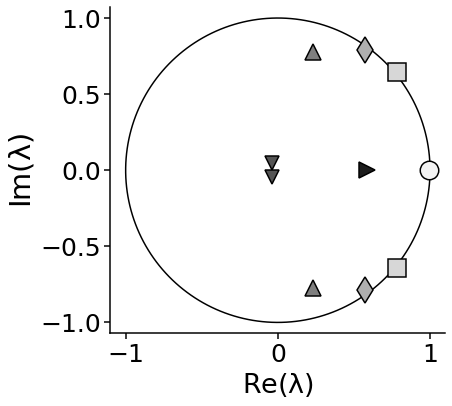

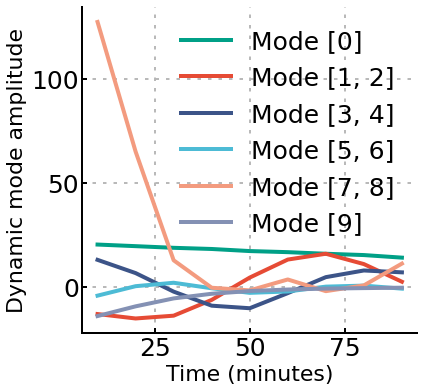

In [195]:
# plot the eigenvalues on the unit circle

savefig = False
# automate mode pairing (data is real-valued, complex eigs comes with a conjugate pair -- no need to plot both)
mode_pairs = []
cnt = 0
while cnt in range(len(eVals_r)): 
    if cnt+1 != len(eVals_r): # have we reached the boundary?
        if np.abs(eVals_r[cnt]) == np.abs(eVals_r[cnt+1]): # if no, then check if the two are c.c. pairs
            mode_pairs.append([cnt,cnt+1])
            cnt += 2
        else: # if no, and not c.c. pairs
            mode_pairs.append([cnt])
            cnt += 1
    else: # if boundary
        mode_pairs.append([cnt])
        cnt += 1
print('mode pairs: ', mode_pairs)

# size the eigenvalue marker by corresponding mode power ||Phi_i||
mode_powers = np.linalg.norm(Phi,axis=0)
my_ms = [9*2**n for n in mode_powers] # the 9*2**n is an arbitrary scaling for marker size

fig1,ax1 = plt.subplots(1,1,figsize=(6,6))
fig2,ax2 = plt.subplots(1,1,figsize=(6,6))
theta = np.linspace(0,2*np.pi,200)
ax1.plot(np.cos(theta),np.sin(theta),c='black',lw=1.5)

markers = ['o','s','d','^','v','>']
cmap = matplotlib.cm.get_cmap('Greys')
grad_colors = [list(cmap(x)[0:3]) for x in np.linspace(0.1,0.9,6)]
for ii in range(len(mode_pairs)):
    scaled_mode = np.real(eVals_r[ii]*b_r1[mode_pairs[ii][0]])

    ax2.plot(corr_tspan,savgol(scaled_mode,3,1),'-',c=npg_colors[ii],lw=4,label='Mode ' + str(mode_pairs[ii]))
#     ax1.plot(np.real(eVals_r[mode_pairs[ii][0]]),np.imag(eVals_r[mode_pairs[ii][0]]),
#                 marker=markers[ii],mfc=npg_color_list[ii]+[0.8],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=2)
#     if len(mode_pairs[ii]) == 2: 
#         ax1.plot(np.real(eVals_r[mode_pairs[ii][1]]),np.imag(eVals_r[mode_pairs[ii][1]]),
#                 marker=markers[ii],mfc=npg_color_list[ii]+[0.8],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=2)
    ax1.plot(np.real(eVals_r[mode_pairs[ii][0]]),np.imag(eVals_r[mode_pairs[ii][0]]),
                marker=markers[ii],mfc=grad_colors[ii],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=1.5)
    if len(mode_pairs[ii]) == 2: 
        ax1.plot(np.real(eVals_r[mode_pairs[ii][1]]),np.imag(eVals_r[mode_pairs[ii][1]]),
                marker=markers[ii],mfc=grad_colors[ii],ms=my_ms[mode_pairs[ii][0]],mec='k',mew=1.5)

ax1.axis('equal')
ax1.set_xlabel(r'$\mathregular{Re(\lambda)}$',fontsize=27)
ax1.set_ylabel(r'$\mathregular{Im(\lambda)}$',fontsize=29)
ax1.set_ylim(-1,1)
ax1.set_yticks(np.arange(-1,1.5,0.5))
ax1.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax1.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')

ax2.set_xlabel('Time (minutes)',fontsize=22)
ax2.set_ylabel('Dynamic mode amplitude',fontsize=22)
ax2.legend(frameon=False,ncol=1)
ax2.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
ax2.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')

for side in ax1.spines.keys():
    ax2.spines[side].set_linewidth(2)

ax2.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
    
if savefig: 
    fig1.savefig(figDir + 'fig2/eigvals.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

r2_score for n-step prediction (reduced): 5.980e-01
r2_score for n-step prediction: 6.615e-01
r2_score for n-step prediction (reduced): 9.192e-01
r2_score for n-step prediction: 8.849e-01
r2_score for n-step prediction (reduced): 9.393e-01
r2_score for n-step prediction: 9.115e-01
r2_score for n-step prediction (reduced): 9.230e-01
r2_score for n-step prediction: 9.208e-01
r2_score for n-step prediction (reduced): 9.465e-01
r2_score for n-step prediction: 9.425e-01
r2_score for n-step prediction (reduced): 1.000e+00
r2_score for n-step prediction: 9.957e-01


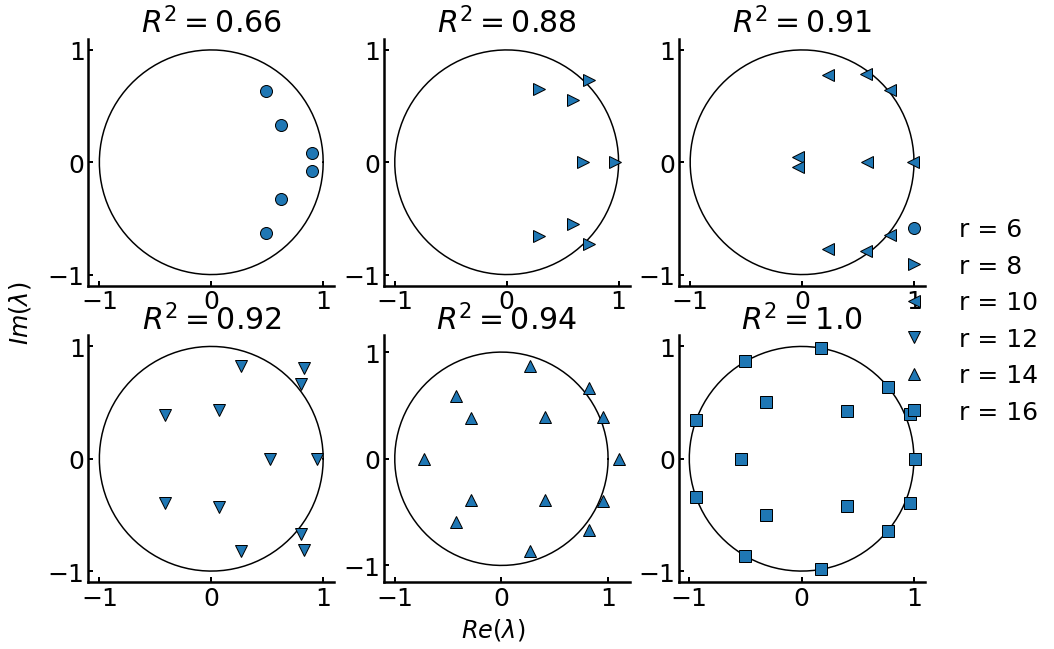

In [30]:
# make a plot that shows magnitude of eigvals for varying r
# supplemental figure

savefig = False

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

r_list = [6,8,10,12,14,16]
evals_list,cd_list = [],[]
for rr in r_list: 
    _,_,_,_,cdr,evals,_,_,_,_ = \
                            dmd(data_fc_norm,rank_reduce=True,r=rr,trim=True,trimThresh=2e-3)
    evals_list.append(evals)
    cd_list.append(cdr)

# fig,ax = plt.subplots(1,1,figsize=(7,7))
# my_ms = ['>','o','<','v','^']
# for ii,evals in enumerate(evals_list):
#     ax.plot(np.sort(np.abs(evals))[::-1],my_ms[ii],mec='k',c=npg_colors[ii],mew=1,ms=12
#             ,label='r = '+str(r_list[ii]))
# for side in ax.spines.keys():
#     ax.spines[side].set_linewidth(2.5)
# ax.set_ylabel(r'$|\mathregular{\lambda}|$',fontsize=26)
# ax.set_xticks(range(0,20,5))
# ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
# ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
# ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
# fig.legend(frameon=False,bbox_to_anchor=(1,0.9))
# if savefig: 
#     plt.savefig(figDir + 'fig2/magEvals_vary_numModes.pdf',bbox_inches='tight',transparent=True,dpi=300)
# plt.show()

fig,axs = plt.subplots(2,3,figsize=(15,10))
theta = np.linspace(0,2*np.pi,100)
my_ms = ['o','>','<','v','^','s']
for ii,ax in enumerate(axs.reshape(-1)):
    ax.plot(np.cos(theta),np.sin(theta),c='k',lw=1.5)
    ax.plot(np.real(evals_list[ii]),np.imag(evals_list[ii]),my_ms[ii],ms=12,label='r = '+str(r_list[ii]),
            c='tab:blue',mec='k')
    ax.set_title(r'$R^2=$' + str(np.round(cd_list[ii],2)))
    for side in ax.spines.keys():
        ax.spines[side].set_linewidth(2.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
    ax.axis('equal')
#         ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
fig.legend(frameon=False,bbox_to_anchor=(1.025,0.663))
fig.text(0.5, 0.05, r'$Re(\lambda)$', ha='center',fontsize=24);
fig.text(0.05, 0.5, r'$Im(\lambda)$', va='center', rotation='vertical',fontsize=24);
if savefig: 
    plt.savefig(figDir + 'supplementalFigs/evals_vary_numModes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()


In [109]:
r_list = list(range(1,17))
cd_list = []
for rr in r_list: 
    _,_,_,_,cdr,_,_,_,_,_ = \
                            dmd(data_fc_norm,rank_reduce=True,r=rr,trim=True,trimThresh=2e-3)
    cd_list.append(cdr)
    

r2_score for n-step prediction (reduced): -3.391e-01
r2_score for n-step prediction: 2.097e-02
r2_score for n-step prediction (reduced): -1.308e-02
r2_score for n-step prediction: 5.491e-02
r2_score for n-step prediction (reduced): 4.650e-01
r2_score for n-step prediction: 4.611e-01
r2_score for n-step prediction (reduced): 6.696e-01
r2_score for n-step prediction: 6.325e-01
r2_score for n-step prediction (reduced): 5.171e-01
r2_score for n-step prediction: 6.136e-01
r2_score for n-step prediction (reduced): 5.980e-01
r2_score for n-step prediction: 6.615e-01
r2_score for n-step prediction (reduced): 5.778e-01
r2_score for n-step prediction: 6.615e-01
r2_score for n-step prediction (reduced): 9.192e-01
r2_score for n-step prediction: 8.849e-01
r2_score for n-step prediction (reduced): 9.381e-01
r2_score for n-step prediction: 9.098e-01
r2_score for n-step prediction (reduced): 9.393e-01
r2_score for n-step prediction: 9.115e-01
r2_score for n-step prediction (reduced): 9.343e-01
r2_sco

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


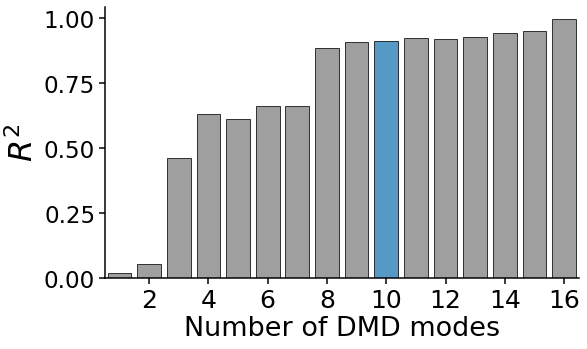

In [225]:
savefig = False

fig,ax = plt.subplots(1,1,figsize=(8.5,5))
color_list = ['tab:gray']*16; color_list[9] = 'tab:blue'
g = sns.barplot(r_list,cd_list,ax=ax,palette=color_list,saturation=1,edgecolor='k',alpha=0.75)
# g.legend_.remove();
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=25)
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=23)
ax.set_xticks(list(range(1,17,2)));
ax.set_xlabel('Number of DMD modes',fontsize=27); ax.set_ylabel(r'$R^2$',fontsize=32)
if savefig: 
    plt.savefig(figDir + 'fig2/R2_vary_numModes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

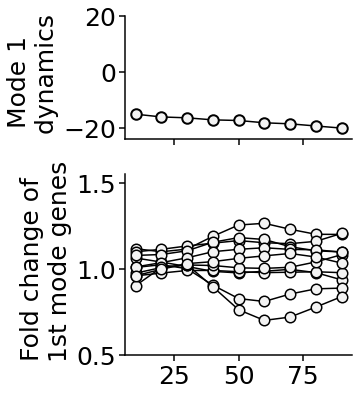

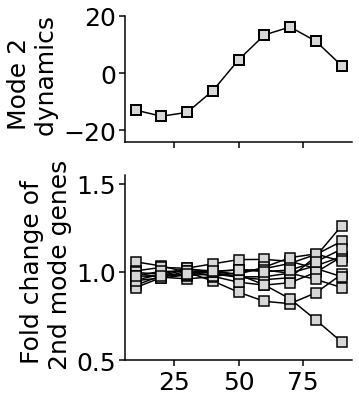

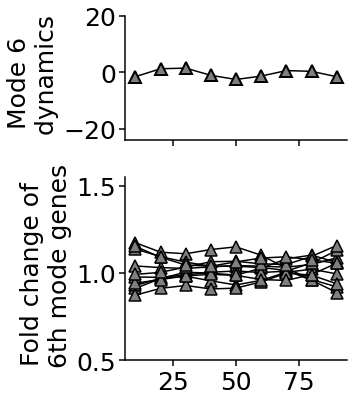

In [382]:
##### cluster genes based on modes

savefig = False

Phi_mag = np.abs(Phi)

kmax = 20 # get most impacted genes
kmax_inds = []
for ii in range(Phi_mag.shape[1]):
    kmax_inds.append(Phi_mag[:,ii].argsort()[-kmax:])

heights = [0.85,1.25]
my_figsize = (4.8,6)

cmap = matplotlib.cm.get_cmap('Greys')
grad_colors = [list(cmap(x)[0:3]) for x in np.linspace(0.1,0.9,6)]

fig1,axs1 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[0]*b_r0[0])
axs1[0].plot(corr_tspan,savgol(scaled_mode,3,1),'o-',ms=10.5,mec='k',mew=2,c='k',mfc=grad_colors[0],lw=1.5)
for ii in range(6,16): # only plot the top 10 
    axs1[1].plot(corr_tspan,savgol(data_fc[kmax_inds[0][ii],:,1],3,1),'o-',c='k',mfc=grad_colors[0],
           ms=10.5,mec='k',mew=1.5,lw=1.5)
for jj,ax in enumerate(axs1.reshape(-1)):
    ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
plt.tight_layout()    
axs1[0].set_ylim(-24,20)
axs1[1].set_ylim(0.5,1.55)
axs1[0].set_ylabel('Mode 1 \n dynamics',fontsize=25) 
axs1[1].set_ylabel('Fold change of \n 1st mode genes',fontsize=25) 

fig2,axs2 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[1]*b_r1[1])
axs2[0].plot(corr_tspan,savgol(scaled_mode,3,1),'s-',ms=10.5,mec='k',mew=2,c='k',mfc=grad_colors[1],lw=1.5)
for ii in range(6,16): # only plot the top 10 
    axs2[1].plot(corr_tspan,savgol(data_fc[kmax_inds[1][ii],:,1],3,1),'s-',c='k',mfc=grad_colors[1],
           ms=10.5,mec='k',mew=1.5,lw=1.5)
for jj,ax in enumerate(axs2.reshape(-1)):
    ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
plt.tight_layout()    
axs2[0].set_ylim(-24,20)
axs2[1].set_ylim(0.5,1.55)
axs2[0].set_ylabel('Mode 2 \n dynamics',fontsize=25) 
axs2[1].set_ylabel('Fold change of \n 2nd mode genes',fontsize=25) 
    
fig3,axs3 = plt.subplots(2,1,figsize=my_figsize,gridspec_kw={'height_ratios':heights},sharey='row',sharex=True)
scaled_mode = np.real(eVals_r[5]*b_r1[5])
axs3[0].plot(corr_tspan,savgol(scaled_mode,3,1),'^-',ms=12,mec='k',mew=2,c='k',mfc=grad_colors[3],lw=1.5)
for ii in range(10,kmax): # only plot the top 10 
    axs3[1].plot(corr_tspan,savgol(data_fc[kmax_inds[3][ii],:,1],3,1),'^-',c='k',mfc=grad_colors[3],
           ms=12,mec='k',mew=1.5,lw=1.5)
for jj,ax in enumerate(axs3.reshape(-1)):
    ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
plt.tight_layout()    
axs3[0].set_ylim(-24,20)
axs3[1].set_ylim(0.5,1.55)
axs3[0].set_ylabel('Mode 6 \n dynamics',fontsize=25) 
axs3[1].set_ylabel('Fold change of \n 6th mode genes',fontsize=25) 

if savefig: 
    fig1.savefig(figDir + 'fig2/mode1_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig2.savefig(figDir + 'fig2/mode2_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
    fig3.savefig(figDir + 'fig2/mode6_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

r2_score for n-step prediction: 9.190e-01


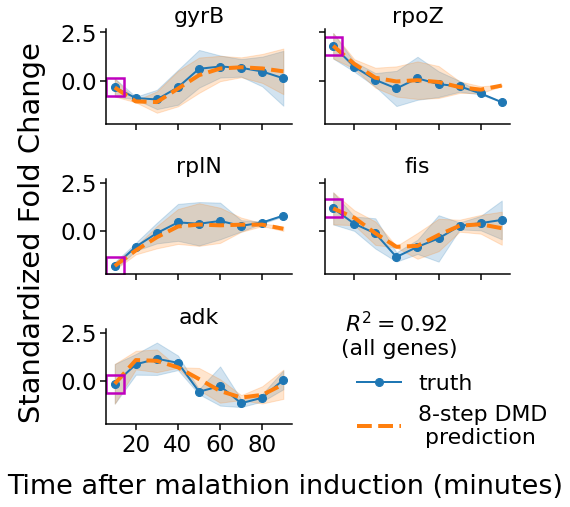

In [217]:
##### visualize the predictions for several randomly selected genes
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

X_pred, cd_ = n_step_prediction(A,data_fc_norm,data_fc_norm.shape[1],data_fc_norm.shape[2])
Xpred = X_pred.reshape(len(A),data_fc_norm.shape[1],data_fc_norm.shape[2],order='F')

fig,axs = plt.subplots(3,2,figsize=(7,7),sharex=True,sharey=True)
fig.delaxes(axs[-1,-1])
pinds = [3,100,583,164,309] # plot these genes (selected randomly)
for ii,ax in enumerate(axs.reshape(-1)):
    if ii < len(pinds):
        pind = pinds[ii]
        act_mean = np.mean(data_fc_norm[pind],axis=1)
        pred_mean = np.mean(Xpred[pind],axis=1)
        act_std = np.std(data_fc_norm[pind],axis=1)
        pred_std = np.std(Xpred[pind],axis=1)
        ax.plot(corr_tspan,act_mean,'o-',ms=8,lw=2,c='tab:blue')
        ax.plot(corr_tspan,pred_mean,'--',lw=4,c='tab:orange')
        ax.fill_between(corr_tspan,act_mean-act_std,act_mean+act_std,color='tab:blue',alpha=0.2)
        ax.fill_between(corr_tspan,pred_mean-pred_std,pred_mean+pred_std,color='tab:orange',alpha=0.2)
        # also plot a marker indicating that the IC is given as input to the model
        ax.plot(10,act_mean[0],'s',ms=18,c='m',mfc='None',mew=2.5)
        ax.set_xticks(range(20,100,20))
        ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=23)
        ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=23)
        if genes_keep[pind] != 'N/A':
            ax.set_title(genes_keep[pind],fontsize=22)
        else: 
            ax.set_title(locus_tags_keep[pind],fontsize=22)

fig.legend(['truth','8-step DMD \n prediction'],frameon=False,loc=(0.61,0.1),fontsize=22);
fig.text(0.5, -0.02, 'Time after malathion induction (minutes)', ha='center',fontsize=27);
fig.text(-0.03, 0.5, 'Standardized Fold Change', va='center', rotation='vertical',fontsize=29);
fig.text(0.72,0.256,r'$R^2=0.92$' '\n (all genes)',ha='center',fontsize=22)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir + 'fig2/error_timeseries.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

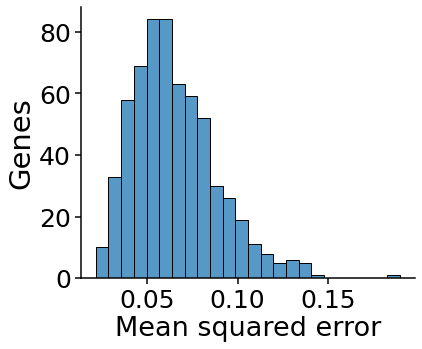

In [226]:
#### visualize the histogram of the per gene residuals

savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

mse_per_gene = (np.linalg.norm(np.linalg.norm(Xpred - data_fc_norm,axis=2),axis=1) 
                / (Xpred.shape[1]*Xpred.shape[2]))

fig, ax = plt.subplots(figsize=(6,5))
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=25)
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=25)
sns.histplot(mse_per_gene)
plt.xlabel('Mean squared error',fontsize=27)
plt.ylabel('Genes',fontsize=29)
if savefig: 
    plt.savefig(figDir + 'fig2/mse_histogram_dmd.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

#### Subfigures for Figure 3 in manuscript

In [37]:
Xo1, Xo1_proj = finite_horizon_obs_gramian(A,V[:,0:1].T,10)
print('Xo1 volume:', np.linalg.det(Xo1_proj))
Xo2, Xo2_proj = finite_horizon_obs_gramian(A,V[:,1:2].T,10)
print('Xo2 volume:', np.linalg.det(Xo2_proj))
Xo3, Xo3_proj = finite_horizon_obs_gramian(A,V[:,2:3].T,10)
print('Xo3 volume:', np.linalg.det(Xo3_proj))

Xo1 volume: 2350.542151695237
Xo2 volume: 629.3356544161887
Xo3 volume: 141.64992258655153


In [38]:
Xo, Xo_proj = finite_horizon_obs_gramian(A,V[:,0:3].T,10)
print('Xo volume:', np.linalg.det(Xo_proj))
# though volume is extremely large when using multiple outputs, can't algorithmically use the multiple outputs
# to identify which genes to select as sensors since the columns and rows of the sampling matrix have 
# do not have just a single '1' for yes do select and '0' everywhere else to say do not select. 

Xo volume: 21105.104193621308


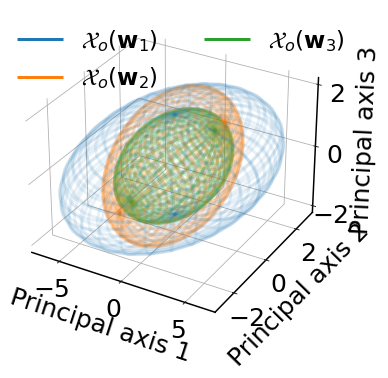

In [39]:
# plot gramian ellipsoids
savefig = False

X1,Y1,Z1 = get_ellipsoid(Xo1_proj)
X2,Y2,Z2 = get_ellipsoid(Xo2_proj)
X3,Y3,Z3 = get_ellipsoid(Xo3_proj)

fig, ax = plt.subplots(1,1,figsize=(6,6),subplot_kw=dict(projection='3d'))

ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:blue',label=r'$\mathcal{X}_o(\mathbf{w}_1)$')
ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:orange',label=r'$\mathcal{X}_o(\mathbf{w}_2)$')
ax.plot_wireframe(np.zeros_like(X1),np.zeros_like(Y1),np.zeros_like(Z1),color='tab:green',label=r'$\mathcal{X}_o(\mathbf{w}_3)$')
ax.plot_wireframe(X1,Y1,Z1, color='tab:blue', alpha=0.1)
ax.plot_wireframe(X2,Y2,Z2, color='tab:orange', alpha=0.15)
ax.plot_wireframe(X3,Y3,Z3, color='tab:green', alpha=0.2)
ax.set_xlabel('Principal axis 1',labelpad=10)
ax.set_ylabel('Principal axis 2',labelpad=10)
ax.set_zlabel('Principal axis 3',labelpad=10)
# get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_ylim(-3,3)
ax.set_xlim(-7,7)
# ax.set_zlim(-2,2)
plt.legend(frameon=False,ncol=2,bbox_to_anchor=(1.1,1.00),fontsize=23)
if savefig: 
    plt.savefig(figDir + 'fig3/gramian_ellipsoids.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

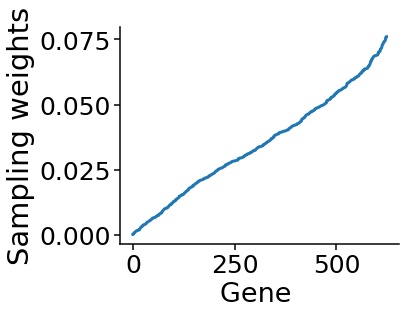

In [19]:
# sampling weights unscaled
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

fig,ax = plt.subplots(1,1,figsize=(5,4))
plt.plot(np.sort(np.abs(W[0])))

ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.set_xlabel('Gene ',fontsize=27);
ax.set_ylabel('Sampling weights',fontsize=29);

if savefig:
    plt.savefig(figDir + 'supplementalFigs/Sampling_weights.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

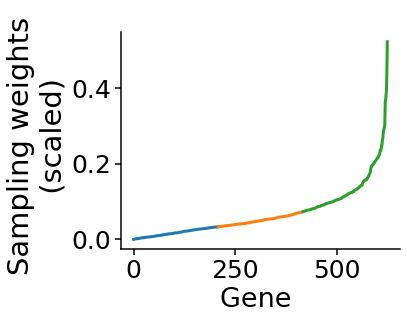

In [70]:
# visualize the weights in gene sampling vector and form three groups
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

# W_scaled = (np.abs(W[0]) - np.abs(W[0]).min())/(np.abs(W[0]).max() - np.abs(W[0]).min())

# # get the indices of the genes with the ngenes/3 largest sampling weights
nInds = int(len(data_fc_norm)/3)
# high_inds = list(np.abs(W[0]).argsort()[-nInds:][::-1])
# low_inds = list(np.abs(W[0]).argsort()[:nInds])
# mid_inds = list(set(list(range(len(W[0])))) - set(high_inds).union(set(low_inds)))

fig,ax = plt.subplots(1,1,figsize=(5,4))
# ax.plot(range(nInds),np.abs(W[0][low_inds]),mew=0.3,ms=10,c='tab:blue',alpha=1)
# ax.plot(range(nInds,2*nInds),np.sort(np.abs(W[0][mid_inds])),mew=0.3,ms=10,c='tab:orange',alpha=1)
# ax.plot(range(2*nInds,3*nInds),np.abs(W[0][high_inds])[::-1],mew=0.3,ms=10,c='tab:green',alpha=1)
ax.plot(range(nInds),np.sort(np.abs(Wn))[0:nInds])
ax.plot(range(nInds,2*nInds),np.sort(np.abs(Wn))[nInds:2*nInds])
ax.plot(range(2*nInds,3*nInds),np.sort(np.abs(Wn))[2*nInds:3*nInds])
# ax.plot([0,len(Ws)],[np.abs(Wn).min(),np.abs(Wn).max()],'--',c='k',lw=1.5,zorder=0)

ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.set_xlabel('Gene ',fontsize=27);
# ax.set_ylabel('Sampling weights',fontsize=29);
ax.set_ylabel('Sampling weights \n (scaled)',fontsize=29);

if savefig:
    plt.savefig(figDir + 'fig3/Sampling_weights.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()


In [71]:
# get the indices of the genes with the ngenes/3 largest sampling weights
nInds = int(len(data_fc_norm)/3)
high_inds = list(np.abs(Wn).argsort()[-nInds:][::-1])
low_inds = list(np.abs(Wn).argsort()[:nInds])
mid_inds = list(set(list(range(len(Wn)))) - set(high_inds).union(set(low_inds)))

def mc_reconstruction(p=50,nT=1,N=100):
    '''
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''
    r2_high = []
    for ii in range(N):
        inds = choices(high_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_high.append(reconstruct_x0(data_fc_norm,nT,A,C))

    r2_mid = []
    for ii in range(N):
        inds = choices(mid_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_mid.append(reconstruct_x0(data_fc_norm,nT,A,C))

    r2_low = []
    for ii in range(N):
        inds = choices(low_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)        
        C[:,set_to_zero] = 0.0
        r2_low.append(reconstruct_x0(data_fc_norm,nT,A,C))
        
    return r2_low, r2_mid, r2_high

# takes several minutes to run
doRun = False
doDump = False
if doRun:
    r2_low_nTlow, r2_mid_nTlow, r2_high_nTlow = mc_reconstruction(p=50,nT=2,N=100) # p=nInds//2
    r2_low, r2_mid, r2_high = mc_reconstruction(p=50,nT=8,N=100) # p=nInds//2 (50)     
    mc_recon_list = [r2_low_nTlow, r2_mid_nTlow, r2_high_nTlow, r2_low, r2_mid, r2_high]

if doDump: 
    pickle.dump(mc_recon_list,open('data/mc_reconstruction.pkl','wb'))    
    
if not doRun:    
    mc_recon_list = pickle.load(open('data/mc_reconstruction.pkl','rb'))

In [72]:
def mc_reconstruction_single(p=50,nT=1,N=100):
    '''
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''

    r2_high = []
    for ii in range(N):
        inds = choices(high_inds,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds) )
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_high.append(reconstruct_x0(data_fc_norm,nT,A,C))
    
    return r2_high


doRun = False
doDump = False
if doRun:
    times = [1,2,3,4,5,6,7,8,9,10]
    r2_times_high = []
    for this_t in times: 
        r2_high = mc_reconstruction_single(p=50,nT=this_t,N=50)
        r2_times_high.append( r2_high )

if doDump:
    pickle.dump(r2_times_high, open('data/mc_reconstruction_highs.pkl','wb'))
    
if not doRun:
    r2_times_high = pickle.load(open('data/mc_reconstruction_highs.pkl','rb'))


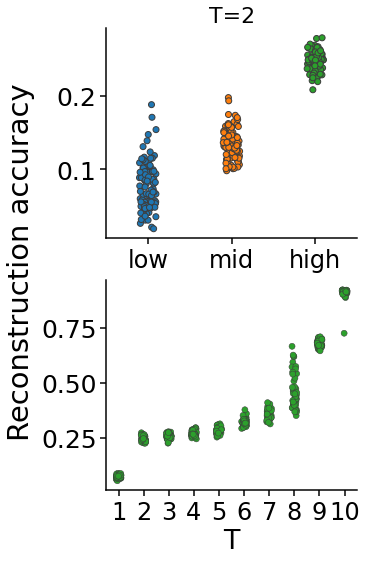

In [74]:
savefig = False

times = [1,2,3,4,5,6,7,8,9,10]


fig,ax=plt.subplots(2,1,figsize=(4.5,8.5),sharex=False,sharey=False) # gridspec_kw={'height_ratios': [1, 1.5]}
sns.stripplot(data=pd.DataFrame(mc_recon_list[0:3]).T,s=6,linewidth=1,ax=ax[0])
sns.stripplot(data=pd.DataFrame(r2_times_high).T,color='tab:green',s=6,linewidth=0.5,ax=ax[1])

fig.text(-0.18, 0.5, 'Reconstruction accuracy', va='center', rotation='vertical',fontsize=29)
ax[0].set_title('T=2',fontsize=22)
for thisax in ax.reshape(-1):
    thisax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
    thisax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax[0].set_xticklabels(['low','mid','high'],fontsize=24)
ax[1].set_xticklabels(times,fontsize=24)
ax[1].set_xlabel('T',fontsize=27)
if savefig:
    plt.savefig(figDir + 'fig3/monte_carlo_reconstruction.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

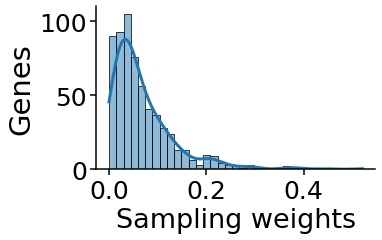

In [75]:
# histogram of the weights in C
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 

fig,ax = plt.subplots(1,1,figsize=(5,3))
# ax.hist((np.abs(Wsorted[0]) - np.abs(Wsorted[0]).min())/(np.abs(Wsorted[0]).max() - np.abs(Wsorted[0]).min()),
#         rwidth=0.825,align='right',linewidth=1.5,edgecolor='k',alpha=0.9)
# sns.histplot((np.abs(Wsorted[0]) - np.abs(Wsorted[0]).min())/(np.abs(Wsorted[0]).max() - np.abs(Wsorted[0]).min()),kde=True,ax=ax)
sns.histplot(np.abs(Wn),kde=True)
# plt.plot([0.05,0.05],[0,100],c='r')

ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.set_xlabel('Sampling weights',fontsize=27);
ax.set_ylabel('Genes',fontsize=29);
if savefig:
    plt.savefig(figDir + 'fig3/sampling_weights_hist.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

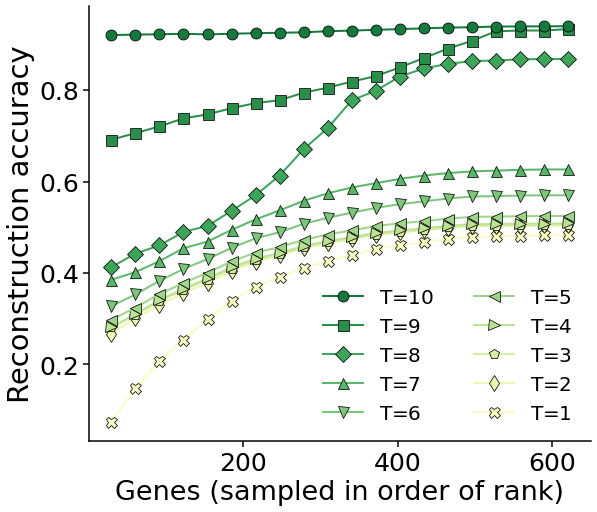

In [76]:
# state estimation error
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False 
plt.rc('lines',linewidth=4);
plt.rc('lines',markersize=16);

cmap = matplotlib.cm.get_cmap('YlGn_r')
grad_colors = [list(cmap(x)[0:3]) for x in np.linspace(0.2,0.9,10)]
fig,ax = plt.subplots(1,1,figsize=(9,8));
mec = 'k'
mew = 0.75
alpha = 1
xrange = np.linspace(samplingFreq,620,len(rho_list[0]))
my_labels = [r'T=$10$',r'T=$9$',r'T=$8$',r'T=$7$',r'T=$6$',r'T=$5$',r'T=$4$',r'T=$3$',r'T=$2$',r'T=$1$']
my_markers = ['o','s','D','^','v','<','>','p','d','X']
for ii in range(len(rho_list)):
    ax.plot(xrange,rho_list[ii],my_markers[ii]+'-',mfc=grad_colors[ii]+[alpha],c=grad_colors[ii]+[alpha],
            mec=mec,mew=mew,ms=11,lw=2,label=my_labels[ii],zorder=10-ii)
# ax.set_xticks([1,20,40,60,80])
ax.set_xlabel('Genes (sampled in order of rank)',fontsize=27);
ax.set_ylabel('Reconstruction accuracy',fontsize=29);
# ax.set_ylabel(r'$\mathregular{\rho(\mathbf{z}_0,\mathcal{O}_T^{\dagger} \mathbf{y})}$',fontsize=26);
ax.legend(frameon=False,ncol=2,fontsize=20)
ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out')
if savefig: 
    plt.savefig(figDir + 'fig3/state_estimation_error.pdf',dpi=300,bbox_inches='tight',transparent=True)    
plt.show();

In [813]:
# # state estimation error compared with random sampling
# savefig = False

# plt.rcParams['axes.spines.right'] = False
# plt.rcParams['axes.spines.top'] = False 
# plt.rc('lines',linewidth=3);

# fig,axs = plt.subplots(2,5,figsize=(19,7),sharex=True,sharey=True);
# mec = 'k'
# mew = 1
# alpha = 0.8
# xrange = np.linspace(samplingFreq,620,len(rho_list[0]))
# my_labels = [r'T=$10$',r'T=$9$',r'T=$8$',r'T=$7$',r'T=$6$',r'T=$5$',r'T=$4$',r'T=$3$',r'T=$2$',r'T=$1$']
# my_markers = ['o','s','D','^','v','<','>','p','d','X']
# for ii,ax in enumerate(axs.reshape(-1)):
#     ax.set_title(my_labels[ii])
#     ax.plot(xrange,rho_list[ii],'k')
#     ax.plot(xrange,rho_rand_list[ii],'--',c='k')
#     for side in ax.spines.keys():
#         ax.spines[side].set_linewidth(2.5)
#     ax.xaxis.set_tick_params(which='both', size=5, width=2, direction='in')
#     ax.yaxis.set_tick_params(which='both', size=5, width=2, direction='in')
#     ax.grid(linestyle=':',linewidth=1.75,dashes=(2,4))
# ax.legend(['ranked sampling','random sampling'],frameon=False,fontsize=12)
# fig.text(0.5, 0.03, 'Number of genes', ha='center',fontsize=22);
# fig.text(0.07, 0.5, 'Reconstruction error', va='center', rotation='vertical',fontsize=24);
# if savefig: 
#     plt.savefig(figDir + 'supplementalFigs/rand_estimation_error.pdf',dpi=300,bbox_inches='tight',transparent=True)    
# plt.show();

In [34]:
def mc_reconstruction_top_n(n=15,p=15,nT=2,N=100):
    '''
    n: top n% of genes only
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''
    r2_list = []
    corr_list = []
    keep_inds = list(np.argsort(np.abs(Wn))[-int(len(Wn)*(n)/100):])
    set_to_zero = list( set(list(range(len(Wn)))) - set(keep_inds) )
    C = deepcopy(Wn)
    C = np.expand_dims(C,axis=0)
    C[:,set_to_zero] = 0.0
    for ii in range(N):
        Cn = deepcopy(C)
        inds = choices(keep_inds,k=p)  
        set_to_zero_n = list(set(keep_inds) - set(inds))
        Cn[:,set_to_zero_n] = 0.0
        r2_list.append(reconstruct_x0(data_fc_norm,nT,A,Cn))
        corr_list.append( 
            np.linalg.norm(np.ones((p,p))-
                           np.abs(np.corrcoef(data_fc_norm[inds].reshape(p,-1,order='F'))),ord='fro') )
    return r2_list, corr_list

doRun = False
doDump = False
if doRun:
    r2_top_n, corr_top_n = mc_reconstruction_top_n(n=15,p=15,nT=nT,N=100)

if doDump:
    pickle.dump([r2_top_n,corr_top_n],open('data/top_n_list.pkl','wb'))

if not doRun:
    r2_top_n, corr_top_n = pickle.load(open('data/top_n_list.pkl','rb'))

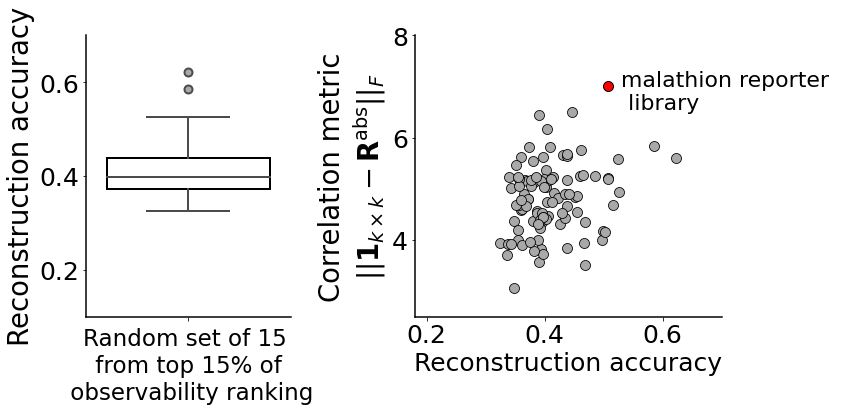

In [36]:
fig,ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios':[0.4,0.6]})
sns.boxplot(data=pd.DataFrame(r2_top_n),color='tab:gray',linewidth=2,ax=ax[0],
            flierprops={"marker": "o","mfc":'darkgray',"mew":2,"ms":8},
            boxprops={'facecolor':'none', 'edgecolor':'k'})
ax[0].set_xticklabels([''],fontsize=24)
ax[0].set_xlabel('Random set of 15 \n from top 15% of \n observability ranking',fontsize=23)
ax[0].set_ylabel('Reconstruction accuracy',fontsize=27.5)
sns.scatterplot(x=r2_top_n,y=corr_top_n,ax=ax[1],color='darkgray',edgecolor='k',s=100)
# chosen gene set 
plt.plot(0.5080958828078517,7.0,'o',c='red',mec='k',ms=10)
ax[1].text(0.53,6.55,'malathion reporter \n library',fontsize=22)
ax[1].set_xlabel('Reconstruction accuracy')
ax[1].set_ylabel('Correlation metric\n' + 
                 r'$|| \mathbf{1}_{k\times k} - \mathbf{R}^{\mathrm{abs}}||_F $',fontsize=27.5)
ax[0].set_ylim(0.1,0.7)
ax[1].set_ylim(2.5,8)
ax[1].set_xlim(0.18,0.7)
plt.tight_layout()
# plt.savefig(figDir + 'supplementalFigs/mc_analysis_top.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

In [37]:
def mc_reconstruction_random(n=300,p=15,nT=2,N=100):
    '''
    n: number of genes to subsample from
    p: number of genes to sample per run
    nT: number of timepoints to sample each gene for
    N: number of runs
    '''
    r2_list = []
    corr_list = []
    rank_list = [] # average rank of gene set
    inds1 = choices(list(range(len(Wn))),k=n)
    for ii in range(N):
        inds2 = choices(inds1,k=p)
        set_to_zero = list(set(list(range(len(Wn)))) - set(inds2))
        C = deepcopy(Wn)
        C = np.expand_dims(C,axis=0)
        C[:,set_to_zero] = 0.0
        r2_list.append(reconstruct_x0(data_fc_norm,nT,A,C))
        corr_list.append( 
            np.linalg.norm(np.ones((p,p))-
                           np.abs(np.corrcoef(data_fc_norm[inds2].reshape(p,-1,order='F'))),ord='fro') )
        rank_list.append( np.mean([list(np.argsort(np.abs(Wn))).index(x) for x in inds2]))
    return r2_list, corr_list, rank_list

doRun = False
doDump = False
if doRun:
    r2_random, corr_random, rank_random = mc_reconstruction_random(n=len(Wn)//2,p=11,nT=6,N=100)
    
if doDump: 
    pickle.dump([r2_random,corr_random,rank_random],open('data/random_list.pkl','wb'))

if not doRun:
    r2_random, corr_random, rank_random = pickle.load(open('data/random_list.pkl','rb'))

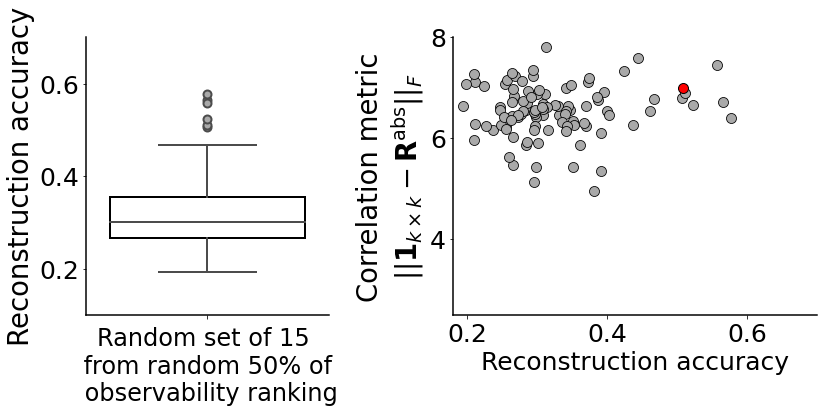

In [38]:
fig,ax = plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios':[0.4,0.6]})
sns.boxplot(data=pd.DataFrame(r2_random),color='tab:gray',linewidth=2,ax=ax[0],
            flierprops={"marker": "o","mfc":'darkgray',"mew":2,"ms":8},
            boxprops={'facecolor':'none', 'edgecolor':'k'})
ax[0].set_xticklabels([''],fontsize=24)
ax[0].set_xlabel('Random set of 15 \n from random 50% of \n observability ranking',fontsize=24)
ax[0].set_ylabel('Reconstruction accuracy',fontsize=27.5)
sns.scatterplot(x=r2_random,y=corr_random,ax=ax[1],edgecolor='k',color='darkgray',s=100)
# chosen gene set 
plt.plot(0.5080958828078517,7.0,'o',c='red',mec='k',ms=10)
# ax[1].text(0.53,6.55,'malathion reporter \n library',fontsize=22)
ax[1].set_xlabel('Reconstruction accuracy'); 
ax[1].set_ylabel('Correlation metric\n' + 
                 r'$|| \mathbf{1}_{k\times k} - \mathbf{R}^{\mathrm{abs}}||_F $',fontsize=27.5)
ax[0].set_ylim(0.1,0.7)
ax[1].set_ylim(2.5,8)
ax[1].set_xlim(0.18,0.7)
plt.tight_layout()
# plt.savefig(figDir + 'supplementalFigs/mc_analysis_random.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()



In [625]:
# reconstruct x0 with only the chosen sensor genes
set_to_zero = list(set(list(range(len(Wn)))) - set(list(df_up_new.tag_ind)))
C = deepcopy(Wn)
C[set_to_zero] = 0.0
C = C.reshape(-1,len(C))
r2 = reconstruct_x0(data_fc_norm,nT,A,C)
print(r2)

0.5080958828078517


In [464]:
# reconstruction x0 using top 15 genes in Wn
set_to_zero = list(set(list(range(len(Wn)))) - set(list(np.argsort(np.abs(Wn))[-15:])))
C = deepcopy(Wn)
C[set_to_zero] = 0.0
C = C.reshape(-1,len(C))
r2 = reconstruct_x0(data_fc_norm,nT,A,C)
print(r2)

0.3874656688125569


7.034548028361538


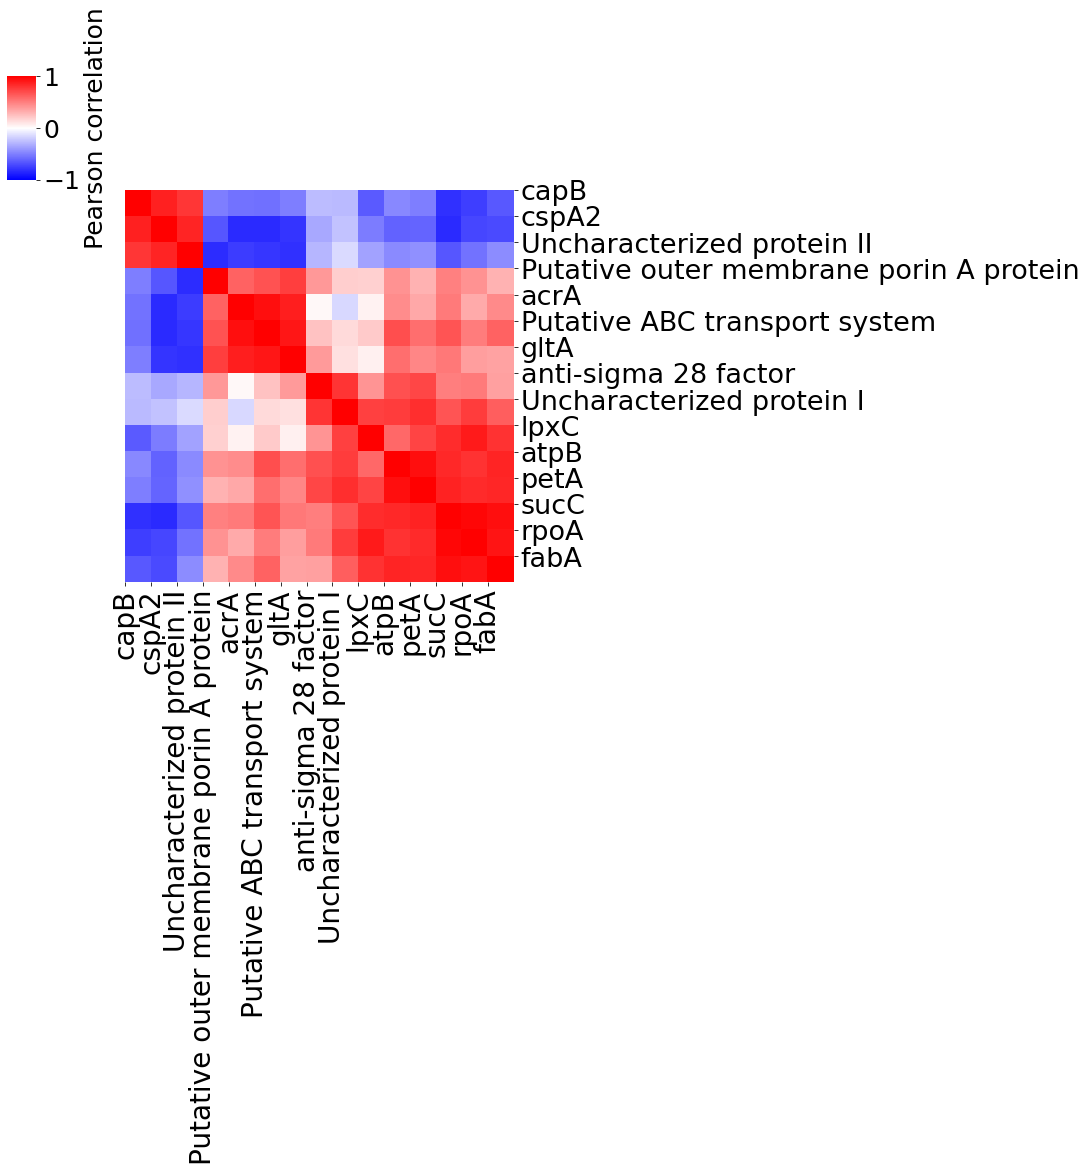

In [373]:
# correlations among chosen sensor genes

cg = sns.clustermap(np.corrcoef(data_fc_norm[list(df_up_new.tag_ind)].reshape(15,-1,order='F')),
           vmax=1,vmin=-1,cmap='bwr',cbar_kws={'label':'Pearson correlation'},figsize=(8,8),)
reordered_inds = cg.dendrogram_col.reordered_ind
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
cg.ax_heatmap.set_xticks(range(len(df_up_new)))
cg.ax_heatmap.set_xticklabels([''.join(list(df_up_new.gene)[x].split('\n ')) for x in reordered_inds],
                             rotation=90,fontsize=28)
cg.ax_heatmap.set_yticks(range(len(df_up_new)))
cg.ax_heatmap.set_yticklabels([''.join(list(df_up_new.gene)[x].split('\n ')) for x in reordered_inds],
                             rotation=0,fontsize=27)
# cg.fig.savefig(figDir + 'supplementalFigs/library_correlations.pdf',dpi=300,transparent=True,bbox_inches='tight')

print( np.linalg.norm( np.ones((15,15)) - np.abs(np.corrcoef(data_fc_norm[list(df_up_new.tag_ind)].reshape(15,-1,order='F'))), ord='fro' ) )

Top 15 genes ranked by Wn

In [361]:
# protein name, molecular function, biological process

df_top_genes = pd.DataFrame({'locus_tag': [locus_tags_keep[x] for x in sorted_inds_n[::-1][:15]],
 'gene': [genes_keep[x] for x in sorted_inds_n[::-1][:15]],
 'protein_name':['50S ribosomal protein L34',
                'Putative outer membrane protein',
                'ATP-dependent Clp protease proteolytic subunit',
                'Translational regulator CsrA',
                'ATP synthase subunit a',
                '30S ribosomal protein S11',
                '50S ribosomal protein L6',
                '50S ribosomal protein L10',
                'ATP synthase subunit b',
                'Coenzyme PQQ synthesis protein A',
                'Ribose-phosphate pyrophosphokinase',
                'Probable Fe(2+)-trafficking protein',
                '30S ribosomal protein S7',
                'Arginine deiminase',
                '50S ribosomal protein L16'],
'molecular function':['structural constituent of ribosome',
                      'N/A',
                      'ATP-dependent peptidase activity; serine-type endopeptidase activity',
                      "mRNA 5'-UTR binding","proton-transporting ATP synthase activity, rotational mechanism",
                      'structural constituent of ribosome',
                      'structural constituent of ribosome',
                      'structural constituent of ribosome',
                      'hydrolase activity; proton-transporting ATP synthase activity, rotational mechanism',
                      'N/A',
                      'ATP binding; kinase activity; magnesium ion binding; ribose phosphate diphosphokinase activiity',
                      'N/A',
                      'rRNA binding; structural constituent of ribosome; tRNA binding',
                      'arginine deiminase activity',
                      'rRNA binding; structural constituent of ribosome; tRNA binding'],
'biological process':['translation',
                     'N/A',
                     'proteolysis',
                     'regulation of translational initation and carbohydrate metabolic process',
                     'N/A',
                     'translation',
                     'translation',
                     'translation',
                     'N/A',
                     'pyrroloquinoline quinone biosynthetic process',
                     '5-phosphoribose 1-diphosphate biosynthetic process; nucleotide biosynthetic process; phosphorylation; ribonucleoside monophosphate biosynthetic process',
                     'N/A',
                     'translation',
                     'arginine catabolic process to  ornithine',
                     'translation'] })

for ii in range(len(df_top_genes)):
    if df_top_genes.gene[ii] == 'N/A':
        df_top_genes.gene[ii] = df_top_genes.protein_name[ii]

2.811107328339542


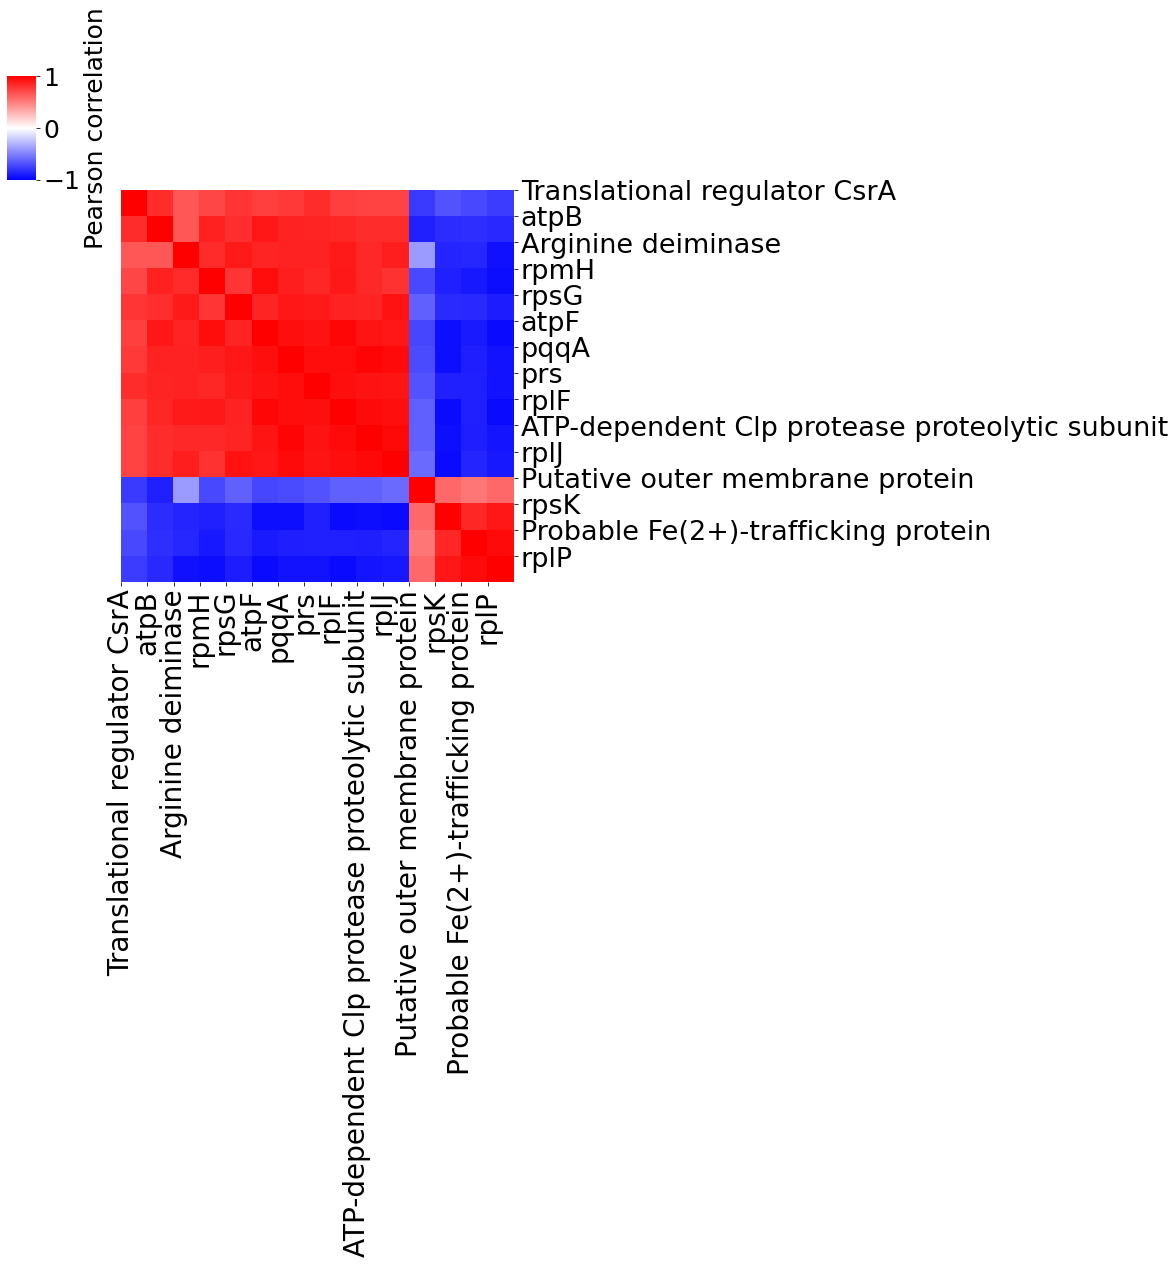

In [374]:
# correlations among top 15 by Wn
cg = sns.clustermap(np.corrcoef(data_fc_norm[list(np.argsort(np.abs(Wn))[-15:])].reshape(15,-1,order='F')),
           vmax=1,vmin=-1,cmap='bwr',cbar_kws={'label':'Pearson correlation'},figsize=(8,8),)
reordered_inds = cg.dendrogram_col.reordered_ind
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
cg.ax_heatmap.set_xticks(range(len(df_up_new)))
cg.ax_heatmap.set_xticklabels([list(df_top_genes.gene)[x] for x in reordered_inds],rotation=90,
                             fontsize=28)
cg.ax_heatmap.set_yticks(range(len(df_up_new)))
cg.ax_heatmap.set_yticklabels([list(df_top_genes.gene)[x] for x in reordered_inds],rotation=0,
                             fontsize=27)
# cg.fig.savefig(figDir + 'supplementalFigs/top_correlations.pdf',dpi=300,transparent=True,bbox_inches='tight')

print( np.linalg.norm( np.ones((15,15)) - np.abs(np.corrcoef(data_fc_norm[list(np.argsort(np.abs(Wn))[-15:])].reshape(15,-1,order='F'))), ord='fro' ) )

In [380]:
# df_top_genes.to_csv(figDir+'supplementalFigs/top_genes.csv')

Correlation strategy for gene selection -- accounts for observability by starting at the highest ranked gene and proceeding from there

In [494]:
# sort genes in data matrix by descending rank and reshape data matrix to 2D (genes x condition)
# corr_cutoff = 0.1
corr_genes_r2s = []
corr_gene_sets = [] 
corr_gene_set_norms = []
# for corr_cutoff in np.linspace(0.1,0.9,50):
# for corr_cutoff in [0.73157895]:
for corr_cutoff in [0.5]: 
    corr_data = data_fc_norm[sorted_inds_n[::-1]].reshape(len(data_fc_norm),-1,order='F')
    corr = np.abs(np.corrcoef(corr_data))

    corr[corr >= corr_cutoff] = 1.0

    corr_gene_list = [sorted_inds_n[::-1][0]]
    this_row = 0
    while len(corr_gene_list) < 15: 
        # get the value, index of the first col of this_row that is less than 1.0
        next_ind = [n for n, this_corr in enumerate(corr[this_row,this_row:]) if this_corr < 1.0][0] 
        this_row = next_ind + this_row
        corr_gene_list.append(sorted_inds_n[::-1][this_row]) # these are the indices in data_fc_norm corresponding to the chosen genes
    corr_gene_sets.append(corr_gene_list)

    # reconstruction accuracy with these selected genes
    set_to_zero = list(set(list(range(len(Wn)))) - set(corr_gene_list))
    C = deepcopy(Wn)
    C[set_to_zero] = 0.0
    C = C.reshape(-1,len(C))
    r2 = reconstruct_x0(data_fc_norm,nT,A,C)
    corr_genes_r2s.append(r2)
    
    # norm of fold change response for the genes in the gene set
    corr_gene_set_norms.append(
        np.linalg.norm(data_fc.reshape(len(data_fc),-1,order='F')[corr_gene_list]) )

In [495]:
corr_gene_sets[0], corr_genes_r2s[0]

([148, 420, 255, 303, 470, 547, 266, 88, 134, 119, 202, 540, 417, 37, 434],
 0.3686117958167725)

In [522]:
print( np.linalg.norm( np.ones((15,15)) - np.abs(np.corrcoef(data_fc_norm[corr_gene_sets[0]].reshape(15,-1,order='F'))), ord='fro' ) )

7.803457772117966


In [523]:
# reconstruct x0 with only the chosen sensor genes
set_to_zero = list(set(list(range(len(Wn)))) - set(corr_gene_sets[0]))
C = deepcopy(Wn)
C[set_to_zero] = 0.0
C = C.reshape(-1,len(C))
r2 = reconstruct_x0(data_fc_norm,nT,A,C)
print(r2)

0.3686117958167725


In [496]:
corr_gene_names = [genes_keep[x] if genes_keep[x] != 'N/A' else locus_tags_keep[x] for x in corr_gene_sets[0]]
corr_ranks = (np.array([sorted_inds_n.index(x) for x in corr_gene_sets[0]])+1)/624

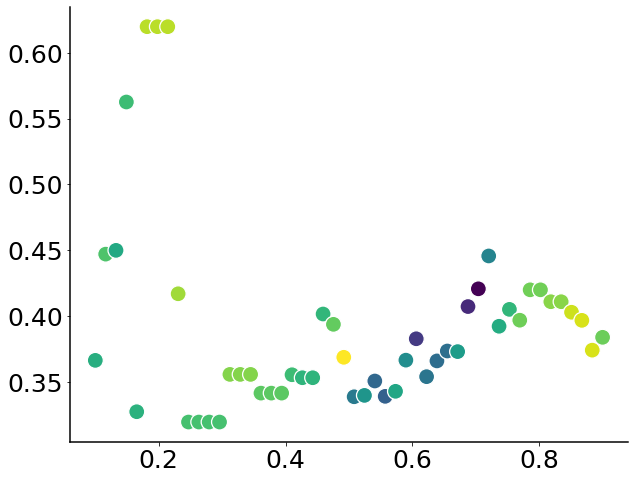

In [255]:
# plot corr_cutoff against reconstruction accuracy and norm of fold change response
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=np.linspace(0.1,0.9,50),y=corr_genes_r2s,c=corr_gene_set_norms)
# plt.show()

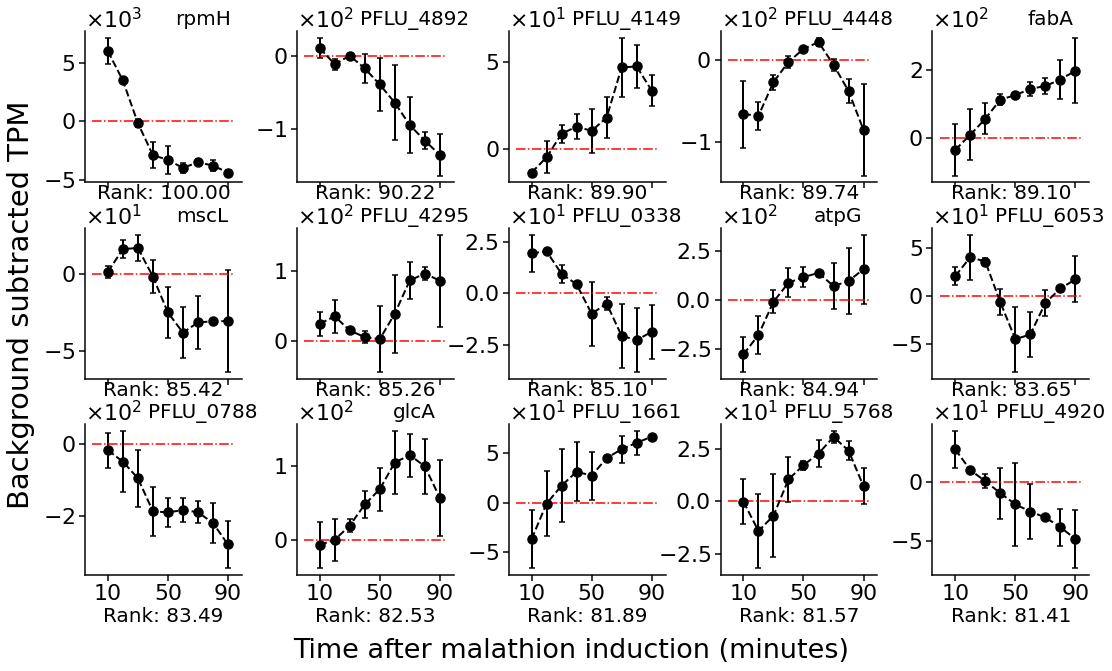

In [815]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True


fig, axs = plt.subplots(3,5,figsize=(18,10),sharex=True); 
for ii,ax in enumerate(axs.reshape(-1)):
    if ii < len(tags):
        ax.set_title(corr_gene_names[ii],fontsize=20,x=0.75)
        pBS = savgol(data_t_orig[keepers][corr_gene_sets[0][ii]] - data_c_orig[keepers][corr_gene_sets[0][ii]],5,2,axis=0)
        mBS = np.mean(pBS,axis=1)
        sBS = np.std(pBS,axis=1)
        ax.errorbar(corr_tspan,mBS[2:],yerr=sBS[2:],fmt='o--',color='k',lw=2,
                    ms=9,mfc='k',mec='k',mew=1.5,capsize=3,elinewidth=2,ecolor='k')
        ax.set_xlabel(f'Rank: {100*corr_ranks[ii]:.2f}',fontsize=20,labelpad=2)
        ax.set_xticks(range(10,90+40,40))
        ax.hlines(0.0,xmin,xmax,color='r',linestyle='-.',lw=1.5)
        ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0),useMathText=True)
        ax.yaxis.get_offset_text().set_fontsize(22)
        ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=22)
        ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=22)
        ymin,ymax = ax.get_ylim()

fig.text(0.5, 0.01, 'Time after malathion induction (minutes)', ha='center',fontsize=27);
fig.text(0.065, 0.5, 'Background subtracted TPM', va='center', rotation='vertical',fontsize=29);
plt.subplots_adjust(wspace=0.35, hspace=0.3)
# plt.savefig(figDir + 'supplementalFigs/corr_genes_rnaseq.pdf',bbox_inches='tight',transparent=True,dpi=300);


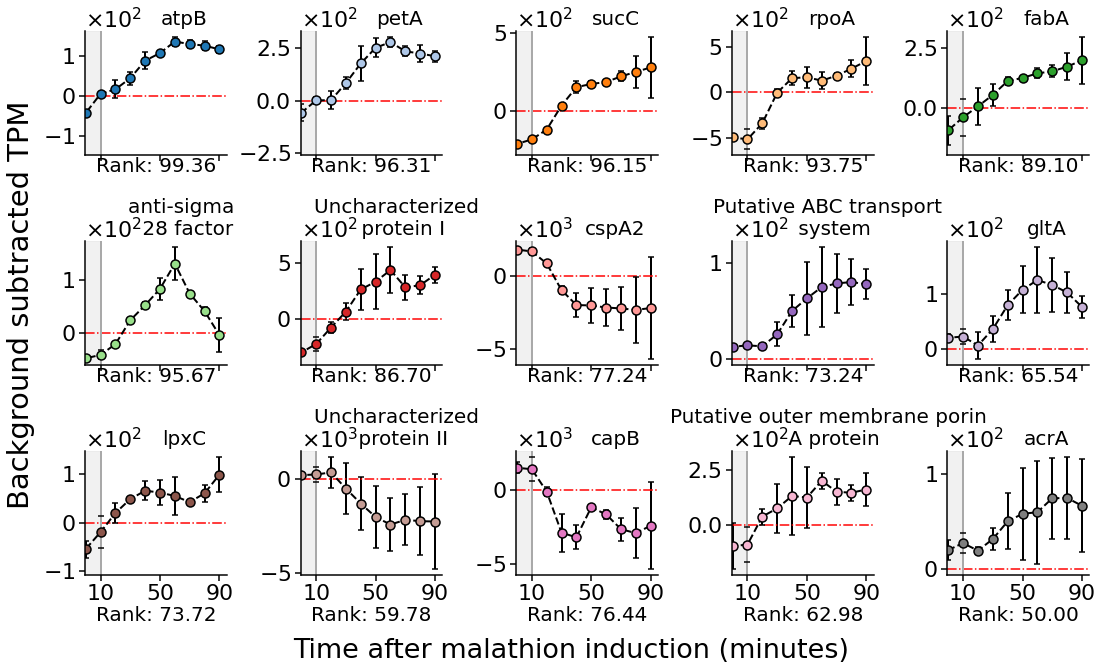

In [676]:
# sensor gene TPMs
savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True

full_tspan = list(range(-10,100,10))

cmap = matplotlib.cm.get_cmap('tab20')

fig, axs = plt.subplots(3,5,figsize=(18,10),sharex=True); 
for ii,ax in enumerate(axs.reshape(-1)):
    if ii < len(tags):
        ax.set_title(df_up_new.gene[ii],fontsize=20,x=0.7)
        pBS = savgol(data_t_orig[keepers][df_up_new.tag_ind[ii]] - data_c_orig[keepers][df_up_new.tag_ind[ii]],5,2,axis=0)
        mBS = np.mean(pBS,axis=1)
        sBS = np.std(pBS,axis=1)
        ax.errorbar(full_tspan,mBS,yerr=sBS,fmt='o--',color='k',lw=2,
                    ms=9,mfc=cmap(ii),mec='k',mew=1.5,capsize=3,elinewidth=2,ecolor='k')
        ax.set_xlabel(f'Rank: {df_up_new.obs_stand_rank[ii]:.2f}',fontsize=20,labelpad=2)
        ax.set_xticks(range(10,90+40,40))
        ax.axvspan(-1,10,color='tab:gray',alpha=0.1)
        ax.set_xlim(-0.5,)
        xmin,xmax = ax.get_xlim()
        ax.hlines(0.0,xmin,xmax,color='r',linestyle='-.',lw=1.5)
        ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0),useMathText=True)
        ax.yaxis.get_offset_text().set_fontsize(22)
        ax.xaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=22)
        ax.yaxis.set_tick_params(which='both', size=6, width=1.5, direction='out',labelsize=22)
        ymin,ymax = ax.get_ylim()
        ax.vlines(10,ymin,ymax,color='darkgray',lw=2)
        ax.set_ylim(ymin,ymax)

fig.text(0.5, 0.01, 'Time after malathion induction (minutes)', ha='center',fontsize=27);
fig.text(0.065, 0.5, 'Background subtracted TPM', va='center', rotation='vertical',fontsize=29);
plt.subplots_adjust(wspace=0.52, hspace=0.7)

if savefig: 
    plt.savefig(figDir + 'fig3/library_genes_rnaseq.pdf',bbox_inches='tight',transparent=True,dpi=300);


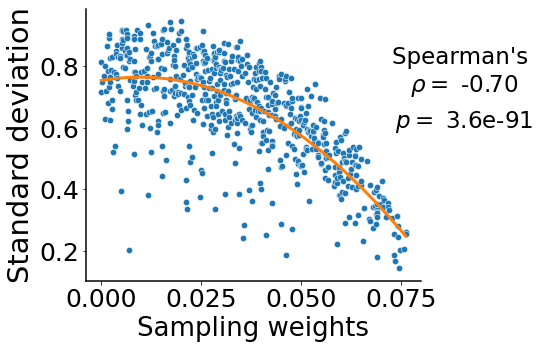

In [449]:
#### Correlate the observability ranking and the gene's standard deviation

savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# gene_std = np.std(np.std(data_fc_norm,axis=2),axis=1)
gene_std = np.mean(np.std(data_fc_norm,axis=2),axis=1)
# W_scaled = (np.abs(W[0]) - np.abs(W[0]).min())/(np.abs(W[0]).max() - np.abs(W[0]).min()) 
W_scaled = np.abs(W[0])
z, cov = np.polyfit(x=W_scaled, y=gene_std, deg=2, cov=True)
# slope, intercept = z[0][0], z[0][1]
# std_slope = np.sqrt(z[1][0,0])
# std_intercept = np.sqrt(z[1][1,1])

rhos, ps = sp.stats.spearmanr(np.sort(W_scaled), gene_std[np.argsort(W_scaled)])

fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(x=np.sort(W_scaled), y=gene_std[np.argsort(W_scaled)], s=40)
plt.plot(np.sort(W_scaled), z[0]*np.sort(W_scaled)**2+z[1]*np.sort(W_scaled)+z[2],color='tab:orange')
# plt.fill_between(np.sort(W_scaled),
#                  (z[0]-cov[0,0])*np.sort(W_scaled)**2+(z[1]-cov[1,1])*np.sort(W_scaled)+(z[2]-cov[2,2]),
#                  (z[0]+cov[0,0])*np.sort(W_scaled)**2+(z[1]+cov[1,1])*np.sort(W_scaled)+(z[2]+cov[2,2]),
#                  color='r',alpha=0.20)
plt.xlabel('Sampling weights',fontsize=26); plt.ylabel('Standard deviation',fontsize=29)
fig.text(1,0.65,"Spearman's \n" + r"$\rho=$ " + f"{rhos:.2f}",ha='center',fontsize=23)
fig.text(1,0.55, r"$p=$ " + f"{ps:.1e}",ha='center',fontsize=23)

    
if savefig: 
    plt.savefig(figDir + 'fig3/correlate_obs_genestd.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

In [55]:
sp.stats.spearmanr(np.sort(W_scaled), gene_std[np.argsort(W_scaled)])

SpearmanrResult(correlation=-0.6942163723916533, pvalue=6.851339223767268e-91)

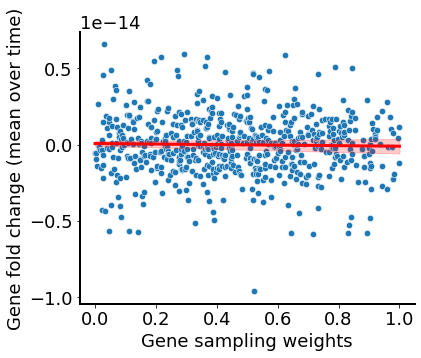

In [252]:
#### Correlate the observability ranking and the gene's mean 

savefig = False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

gene_mean = np.mean(np.mean(data_fc_norm,axis=2),axis=1)
W_scaled = (np.abs(W[0]) - np.abs(W[0]).min())/(np.abs(W[0]).max() - np.abs(W[0]).min()) 
z = np.polyfit(x=W_scaled, y=gene_mean, deg=1, cov=True)
slope, intercept = z[0][0], z[0][1]
std_slope = np.sqrt(z[1][0,0])
std_intercept = np.sqrt(z[1][1,1])

fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(x=np.sort(W_scaled), y=gene_mean[np.argsort(W_scaled)], s=40)
plt.plot(np.sort(W_scaled), slope*np.sort(W_scaled)+intercept,color='red')
plt.fill_between(np.sort(W_scaled),(slope-std_slope)*np.sort(W_scaled)+(intercept-std_intercept),
                 (slope+std_slope)*np.sort(W_scaled)+(intercept+std_intercept),color='r',
                alpha=0.20)
plt.xlabel('Gene sampling weights'); plt.ylabel('Gene fold change (mean over time)')
for ax_ in ['bottom','left']: 
    ax.spines[ax_].set_linewidth(2)
    
if savefig: 
    plt.savefig(figDir + 'fig3/correlate_obs_genemean.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

In [397]:
# differential expression comparisons

deseq_df6 = pd.read_csv('data/deseq_t6.csv')
deseq_df7 = pd.read_csv('data/deseq_t7.csv')
deseq_df8 = pd.read_csv('data/deseq_t8.csv')
deseq_df9 = pd.read_csv('data/deseq_t9.csv')
deseq_df10 = pd.read_csv('data/deseq_t10.csv')
deseq_df11 = pd.read_csv('data/deseq_t11.csv')

deseq_files = ['deseq_t6','deseq_t7','deseq_t8','deseq_t9','deseq_t10','deseq_t11']
li = []
for file in deseq_files: 
    li.append(pd.read_csv('data/'+file + '.csv' ) )

deseq_df = pd.concat(li, axis=0, ignore_index=True)
# get union of tx_ids (due to some being repeated)
deseq_ids = list(set( list(deseq_df.tx_id) ))

# convert tx_ids to locus_tags
de_genes, de_tags, _ = getRecords(cdsFasta_path,genbank_path,deseq_ids)

# get the top n locus_tags from obs ranking, where n = len(deseq_ids)
top_n_tags = [x for ii, x in enumerate(sorted_tags_n[::-1]) if ii < len(de_tags)]

In [398]:
genes_in_common = set(top_n_tags).intersection(de_tags)
print('genes in common between the dge analysis and the top n observability ranked genes')
df_up_new[df_up_new.locus_tag.isin(genes_in_common)]


genes in common between the dge analysis and the top n observability ranked genes


,gene,locus_tag,tag_ind,obs_rank,obs_stand_rank,obs_stand_shrink_rank
0,atpB,PFLU_6124,140,99.52,99.36,89.42
8,Putative ABC transport \n system,PFLU_0376,104,80.61,73.24,82.69
12,capB,PFLU_1302A,335,67.79,77.08,53.69


In [399]:
len(de_tags), len(top_n_tags)

(180, 180)

In [400]:
len(genes_in_common), len(set(de_tags)-set(top_n_tags)), len(set(top_n_tags)-set(de_tags))

(31, 149, 149)

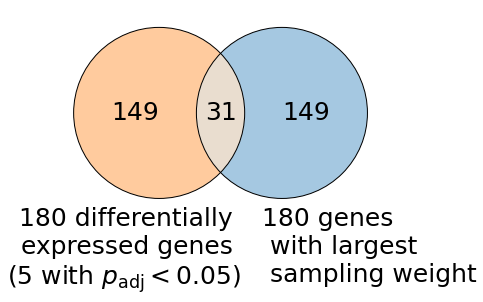

In [462]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted

savefig = False

venn = venn2(subsets = (len(set(de_tags)-set(top_n_tags)), len(set(top_n_tags)-set(de_tags)), len(genes_in_common) ), 
      set_labels = (f'{len(de_tags)} differentially \n expressed genes \n' + r'(5 with $p_{\mathrm{adj}} < 0.05$)',
                    f'{len(de_tags)} genes \n with largest \n sampling weight'),
            set_colors=('tab:orange', 'tab:blue'))


venn.set_labels[0].set_x(0.1)
venn.set_labels[1].set_x(0.2)
for text in venn.set_labels:
    text.set_fontsize(25)
    
for text in venn.subset_labels:
    text.set_fontsize(25)

venn2_circles(subsets = (len(set(de_tags)-set(top_n_tags)), 
                         len(set(top_n_tags)-set(de_tags)), len(genes_in_common) ),
                         linewidth=1);

if savefig: 
    plt.savefig(figDir + 'fig3/methods_overlap_venn.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

In [402]:
df_all = pd.read_csv('data/tpm.csv')
# getting transcriptome dynamics
df_all = df_all[df_all.geneID.isin(deseq_ids)]
txIDs_all = list(df_all.iloc[:,0])
df_all = df_all.iloc[:,1:]
# 
_, _, data_c_all, data_t_all, _, _, _, _, _, _ = process_df(df_all,sampleLabels,nreps,reps,ntimepts,txIDs_all)
data_fc_all = (data_t_all + 20)/(data_c_all + 20)

In [403]:
# data_fc_fair = (data_t + 20 )/(data_c + 20)
# data_fc_fair1 = data_fc_fair.reshape(len(data_fc_fair),data_fc_fair.shape[1]*data_fc_fair.shape[2],order='F')
# scaler = StandardScaler()
# scaler.fit(data_fc_fair1.T) 
# data_fc_fair1 = scaler.transform(data_fc_fair1.T).T
# data_fc_fair = data_fc_fair1.reshape(len(data_fc_fair1),9,2,order='F')
# A_fair,_,_,_,_,_,_,_,_,_ = \
#         dmd(data_fc_fair,rank_reduce=True,r=r,trim=False,trimThresh=2.5e-3) #trimThesh=2.5e-3
# G_fair = gram_matrix(A_fair,data_fc_fair[:,0,:],nT=nT,reduced=False)
# D_fair, V_fair = sp.linalg.eig(G_fair,left=False,right=True)
# W_fair = V_fair[:,0:1].T
# data_fc_fair_nonnorm = (data_t + 20 )/(data_c + 20)

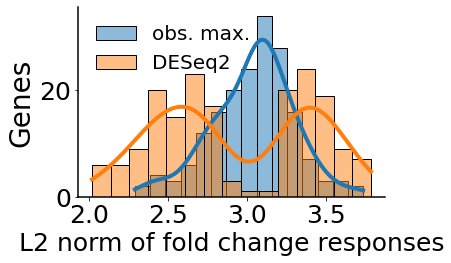

In [404]:
savefig = False

plt.figure(figsize=(5.5,3.5))
sns.histplot(np.linalg.norm(np.mean(data_fc[[locus_tags_keep.index(this_tag) for this_tag in top_n_tags]],
                                    axis=2),axis=1),bins=15,kde=True,label='obs. max.',)
# sns.histplot(np.linalg.norm(np.mean(data_fc_fair_nonnorm[np.argsort(np.abs(W_fair[0]))[-len(data_fc_all):]],axis=2),axis=1)
#                           ,bins=15,kde=True,label='obs. max.',)
sns.histplot(np.linalg.norm(np.mean(data_fc_all,axis=2),axis=1),bins=15,kde=True,color='tab:orange',label='DESeq2')
# sns.kdeplot(np.linalg.norm(np.mean(data_fc[[locus_tags_keep.index(this_tag) for this_tag in top_n_tags]],axis=2)
#                            ,axis=1),shade=True,label='obs. max.')
# sns.kdeplot(np.linalg.norm(np.mean(data_fc_all,axis=2),axis=1),shade=True,color='tab:orange',label='DESeq2')
plt.legend(frameon=False,fontsize=20)
plt.xlabel('L2 norm of fold change responses',fontsize=25)
plt.ylabel('Genes',fontsize=28)
if savefig: 
    plt.savefig(figDir + 'fig3/compare_methods_hist.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

How about the genes that are differentially expressed after multiple-testing correction? 

In [405]:
de_corrected_genes, de_corrected_tags, _ = getRecords(cdsFasta_path,genbank_path,deseq_df[deseq_df.padj < 0.05].tx_id.tolist())

In [406]:
de_corrected_id_inds = [txIDs.index(this_id) for this_id in deseq_df[deseq_df.padj < 0.05].tx_id.tolist()]

In [407]:
inds_in_common_corrected = [locus_tags_keep.index(this_tag) for 
                             this_tag in de_corrected_tags if this_tag in locus_tags_keep]

In [408]:
inds_in_common_corrected

[36, 540, 283, 362, 342]

In [410]:
tags_common = [locus_tags_keep[ii] for ii in inds_in_common_corrected]
genes_common = [genes_keep[ii] for ii in inds_in_common_corrected]
tags_common, genes_common

(['PFLU_0093', 'PFLU_5278', 'PFLU_1150', 'PFLU_1412', 'PFLU_4556'],
 ['gltP', 'glcA', 'bfr1', 'N/A', 'N/A'])

In [441]:
# rank of genes_common_corrected in obs. max. 
pr_deseq2 = [np.argsort(np.abs(Wn)).tolist().index(inds_in_common_corrected[ii])/(len(data_fc)) for ii in range(len(inds_in_common_corrected))]
pr_deseq2

[0.421474358974359,
 0.8237179487179487,
 0.5496794871794872,
 0.5480769230769231,
 0.9246794871794872]

In [413]:
common_dict = \
{this_tag:[locus_tags_keep.index(this_tag),de_corrected_id_inds[ii]] for ii, this_tag in enumerate(de_corrected_tags) if this_tag in locus_tags_keep}
common_dict

{'PFLU_0093': [36, 81],
 'PFLU_5278': [540, 3760],
 'PFLU_1150': [283, 943],
 'PFLU_1412': [362, 1150],
 'PFLU_4556': [342, 3136]}

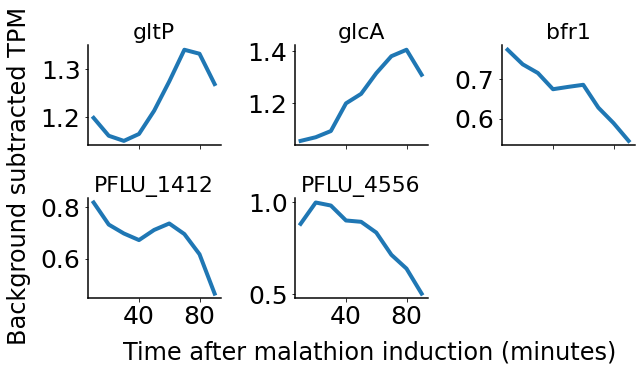

In [418]:
fig, ax = plt.subplots(2,3,figsize=(9,5),sharex=True,sharey=False)
fig.delaxes(ax[-1,-1])
plt.setp(ax,xticks=[40,80],xticklabels=[40,80])
ax = ax.reshape(-1)
for ii,tag in enumerate(common_dict): 
    if genes_common[ii] != 'N/A':
        ax[ii].set_title(genes_common[ii],fontsize=22)
    else:
        ax[ii].set_title(tags_common[ii],fontsize=22)
    ax[ii].plot(corr_tspan,np.mean(data_fc[common_dict[tag][0]],axis=1))
fig.text(0.55, -0.01, 'Time after malathion induction (minutes)', ha='center',fontsize=24);
fig.text(-0.01, 0.5, 'Background subtracted TPM', va='center', rotation='vertical',fontsize=24);
plt.tight_layout()
# plt.savefig(figDir + 'supplementalFigs/dges_tpm.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

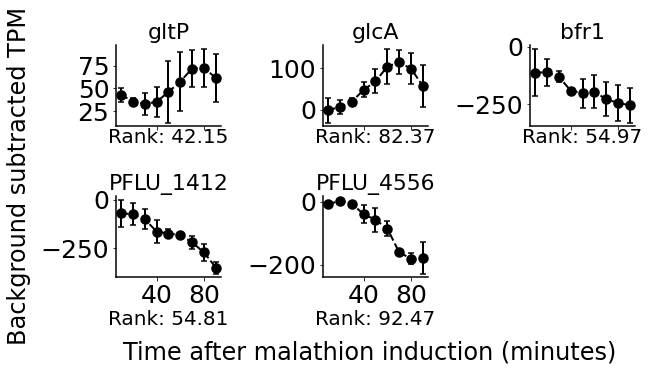

In [458]:
fig, ax = plt.subplots(2,3,figsize=(9,5),sharex=True,sharey=False)
fig.delaxes(ax[-1,-1])
plt.setp(ax,xticks=[40,80],xticklabels=[40,80])
ax = ax.reshape(-1)
for ii,tag in enumerate(common_dict): 
    if genes_common[ii] != 'N/A':
        ax[ii].set_title(genes_common[ii],fontsize=22)
    else:
        ax[ii].set_title(tags_common[ii],fontsize=22)
        
        
    pBS = data_t[common_dict[tag][1]] - data_c[common_dict[tag][1]]
#     pBS = savgol( np.mean(data_t[common_dict[tag][1]],axis=1) - np.mean(data_c[common_dict[tag][1]],axis=1) ,5,2,axis=0)
    mBS = np.mean(pBS,axis=1)
    sBS = np.std(pBS,axis=1)    
#     sBS =  np.sqrt(np.std(data_t[common_dict[tag][1]],axis=1)**2 + np.std(data_c[common_dict[tag][1]],axis=1)**2) 
#     ax[ii].plot(corr_tspan,pBS)
    ax[ii].errorbar(corr_tspan,mBS,yerr=sBS,fmt='o--',color='k',lw=2,
                    ms=9,mec='k',mew=1.5,capsize=3,elinewidth=2,ecolor='k') # mfc=cmap(ii)
#     ax[ii].errorbar(corr_tspan,np.mean(data_t[common_dict[tag][1]],axis=1) - np.mean(data_c[common_dict[tag][1]],axis=1) -
#                         (np.std(data_t[common_dict[tag][1]],axis=1) + np.std(data_c[common_dict[tag][1]],axis=1)), 
#                                    np.mean(data_t[common_dict[tag][1]],axis=1) - np.mean(data_c[common_dict[tag][1]],axis=1) + 
#                         (np.std(data_t[common_dict[tag][1]],axis=1) + np.std(data_c[common_dict[tag][1]],axis=1)),
#                        color='tab:blue',alpha=0.2)
    ax[ii].set_xlabel(f'Rank: {100*pr_deseq2[ii]:.2f}',fontsize=20,labelpad=2)

fig.text(0.55, -0.01, 'Time after malathion induction (minutes)', ha='center',fontsize=24);
fig.text(-0.01, 0.5, 'Background subtracted TPM', va='center', rotation='vertical',fontsize=24);
plt.tight_layout()
# plt.savefig(figDir + 'supplementalFigs/dges_tpm.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [232]:
# need to go back to txID to get logfoldchanges
[de_corrected_tags[ii] for ii in [0,4,7,8,-2]], [deseq_df[deseq_df.padj < 0.05].tx_id.tolist()[ii] for ii in [0,4,7,8,-2]]

(['PFLU_0093', 'PFLU_5278', 'PFLU_1150', 'PFLU_1412', 'PFLU_4556'],
 ['lcl|AM181176.4_cds_CAY46377.1_92',
  'lcl|AM181176.4_cds_CAY52386.1_5161',
  'lcl|AM181176.4_cds_CAY47412.1_1124',
  'lcl|AM181176.4_cds_CAY47665.1_1377',
  'lcl|AM181176.4_cds_CAY51277.1_4457'])

In [242]:
log2foldchanges = deseq_df[deseq_df.padj < 0.05].reset_index(drop=True).loc[[0,4,7,8,10]].log2FoldChange.tolist()
log2foldchanges_se = deseq_df[deseq_df.padj < 0.05].reset_index(drop=True).loc[[0,4,7,8,10]].lfcSE.tolist()
obsmaxranks = [np.argsort(np.abs(W[0])).tolist().index(inds_in_common_corrected[ii])/624 for ii in range(len(inds_in_common_corrected))]

In [248]:
[2**lfc for lfc in log2foldchanges]

[1.4915591623769378,
 1.5424503060046975,
 0.5233073437363313,
 0.5573753930453956,
 0.5512219815939474]

Comparing the 180 differently expressed genes to the top 180 observable genes, we see an set intersection with size 30

In [341]:
# rank de_genes by their log2foldchange

# first average values of duplicated tx_ids (differentially expressed in multiple time points)
from collections import Counter
dups = [k for (k,v) in Counter(deseq_df.tx_id.tolist()).items() if v > 1]

log2FoldChanges = {}
for tx in deseq_ids:
    if tx in dups: 
        log2FoldChanges[tx] = deseq_df[deseq_df.tx_id.isin([tx])].log2FoldChange.mean()
    else: 
        log2FoldChanges[tx] = list(deseq_df[deseq_df.tx_id.isin([tx])].log2FoldChange)[0]
        
log2FoldChanges = pd.DataFrame(log2FoldChanges.items(),columns=['tx_id','log2FoldChange'])

# log2FoldChanges.tx_id to .tag
de_genes, de_tags, _ = getRecords(cdsFasta_path,genbank_path,log2FoldChanges.tx_id.tolist())
log2FoldChanges.tx_id = de_tags
log2FoldChanges['gene'] = de_genes
log2FoldChanges.columns = ['tag','log2FoldChange','gene']
log2FoldChanges.sort_values(by='log2FoldChange',key=abs)
log2FoldChanges['de_rank'] = list(range(len(log2FoldChanges)))
# keep only the fold changes for genes that are also modeled with observability
keep_tags = list(set(log2FoldChanges.tag.tolist()).intersection(locus_tags_keep))
log2FoldChanges = log2FoldChanges[log2FoldChanges.tag.isin(keep_tags)]
log2FoldChanges = log2FoldChanges.reset_index(drop=True)

In [342]:
de_gene_tag = []
for ii, gene in enumerate(log2FoldChanges.gene.tolist()): 
    if gene == 'N/A': 
        de_gene_tag.append(log2FoldChanges.tag.tolist()[ii])
    else: 
        de_gene_tag.append(gene)

In [343]:
obs_df = pd.DataFrame({sorted_tags[ii]: Wsorted[0,ii] for ii in range(len(sorted_tags))}.items(),columns=['tag','obs'])
obs_df['obs_rank'] = list(range(len(obs_df)))
obs_df = obs_df[obs_df.tag.isin(keep_tags)]
obs_df = obs_df.set_index('tag')
obs_df = obs_df.reindex(index=log2FoldChanges['tag'])
obs_df = obs_df.reset_index()

In [344]:
sp.stats.spearmanr(obs_df.obs_rank,log2FoldChanges.de_rank)

SpearmanrResult(correlation=-0.16929419399167842, pvalue=0.16754403020378422)

In [346]:
pd.DataFrame(
    ((obs_df.obs_rank - min(obs_df.obs_rank)) / (max(obs_df.obs_rank) - min(obs_df.obs_rank))
    ,(log2FoldChanges.de_rank-min(log2FoldChanges.de_rank))/
     (max(log2FoldChanges.de_rank)-min(log2FoldChanges.de_rank)) ))

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
obs_rank,0.670017,0.165829,0.361809,0.561139,0.785595,1.000000,0.604690,0.678392,0.934673,0.775544,...,0.333333,0.343384,0.914573,0.115578,0.735343,0.237856,0.132328,0.780570,0.618090,0.58124
de_rank,0.000000,0.005587,0.011173,0.016760,0.033520,0.039106,0.044693,0.089385,0.106145,0.111732,...,0.832402,0.877095,0.882682,0.916201,0.921788,0.938547,0.960894,0.972067,0.994413,1.00000


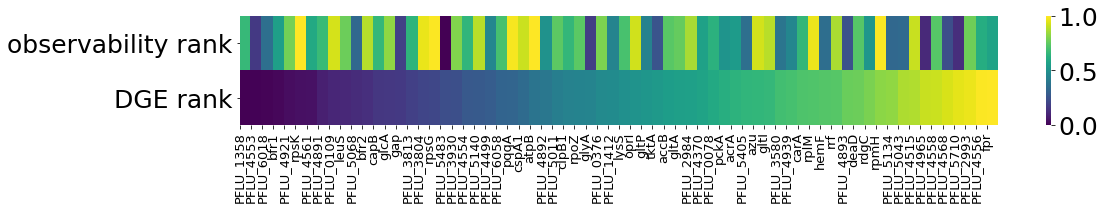

In [345]:

savefig = False

plt.figure(figsize=(17,2))
sns.heatmap(pd.DataFrame(
    ((obs_df.obs_rank - min(obs_df.obs_rank)) / (max(obs_df.obs_rank) - min(obs_df.obs_rank))
    ,(log2FoldChanges.de_rank-min(log2FoldChanges.de_rank))/
     (max(log2FoldChanges.de_rank)-min(log2FoldChanges.de_rank)) )),
     cmap='viridis',yticklabels=['observability rank','DGE rank'], xticklabels=de_gene_tag)
plt.xticks(list(range(len(obs_df))),de_gene_tag,fontsize=13)
# plt.tight_layout()
if savefig: 
    plt.savefig(figDir + 'deseq_comparisons/methods_rank_comparison.pdf',bbox_inches='tight',transparent=True,dpi=300);
plt.show()

In [264]:
# how many of the differentially expressed genes are in the actual library and what is their rank? 
log2FoldChanges[log2FoldChanges.tag.isin(df_up_new.locus_tag.tolist())]

,tag,log2FoldChange,gene,de_rank
0,PFLU_1358,-0.537781,N/A,0
11,PFLU_0376,0.465435,N/A,43
19,PFLU_6124,0.286628,atpB,67
52,PFLU_1815,0.308465,gltA,140
57,PFLU_1380,0.415090,acrA,149
67,PFLU_1302A,-0.375223,capB,177


#### subfigures for sensor placement results 

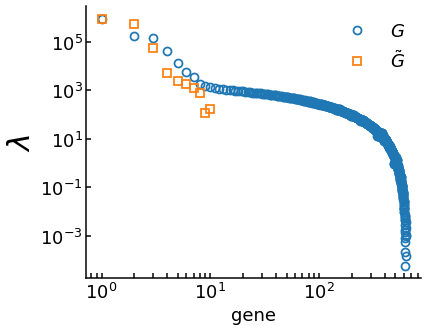

In [44]:
# compare the eigenvalues of the three Gram matrices
savefig=False
# plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(np.linspace(1,len(D),len(D)),np.real(D),'o',mfc='None',ms=8,mew=1.75,label=r'$G$')
ax.plot(np.linspace(1,len(Dt),len(Dt)),np.real(Dt),'s',mfc='None',ms=8,mew=1.75,label=r'$\tilde{G}$')
# ax.plot(np.linspace(1,len(D),len(D)),np.real(Dt_recon),'v',mfc='None',ms=8,mew=1.75,label=r'$U_r\tilde{G}U_r^\top$')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xticks([])
ax.set_xlabel('gene')
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(1.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
ax.set_ylabel(r'$\lambda$',fontsize=30)
plt.legend(frameon=False,ncol=1)
if savefig: 
    plt.savefig(figDir + 'supplementalFigs/gram_eigvals.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


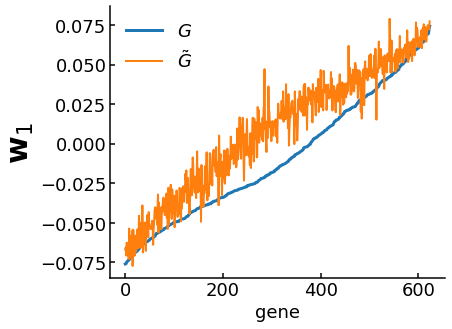

In [45]:
# compare top eigenvector of the three Gram matrices
savefig=False
# plt.style.use('dark_background')
# dark_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
fig, ax = plt.subplots(1,1,figsize=(6,5))
these_inds = np.argsort(V[:,0])
ax.plot(V[:,0][these_inds],label=r'$G$')
# ax.plot(np.linspace(0,623,10),np.sort(Vt[:,0]),label=r'$\tilde{G}$')
ax.plot((np.real(Vt_recon[:,0][these_inds]))[::-1],lw=2,label=r'$\tilde{G}$') # actually eigenvec of projected up \tilde{G} but to avoid confusion using \tilde{G}
# ax.set_xticks([])
ax.set_xlabel('gene')
for side in ax.spines.keys():
    ax.spines[side].set_linewidth(1.5)
    ax.xaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
    ax.yaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
ax.set_ylabel(r'$\mathbf{w}_1$',fontsize=30)
plt.legend(frameon=False,ncol=1)
if savefig: 
    plt.savefig(figDir + 'supplementalFigs/gram_eigvec.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

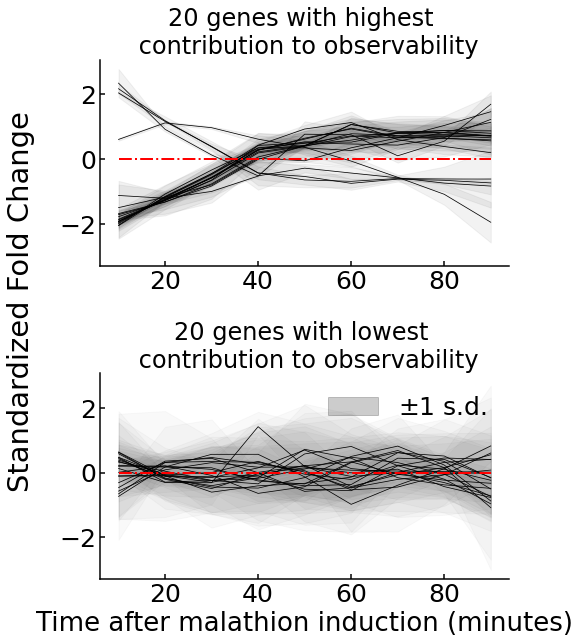

In [844]:
# plot genes which contribute most and least to observability 
savefig = False
ngenes = 20
fig, ax = plt.subplots(2,1,figsize=(7,9.5),sharey=True) # 7,11
for cnt,ii in enumerate(range(len(A)-1,len(A)-ngenes+1,-1)): 
    ax[0].set_title(str(ngenes)+' genes with highest \n contribution to observability',fontsize=24)
    mu = np.mean(data_fc_norm[sorted_inds_n[ii]],axis=1)
    std = np.std(data_fc_norm[sorted_inds_n[ii]],axis=1)
    ax[0].plot(corr_tspan,mu,'-',c='k',mfc='white',ms=2,mew=5,lw=0.75,zorder=1)
    ax[0].fill_between(corr_tspan,mu-std,mu+std,color='k',alpha=0.05,zorder=0)
ax[0].plot([10,90],[0,0],color='r',linestyle='-.',lw=2,zorder=1)
# ax[0].set_ylabel('Fold change',fontsize=24)
# plt.xlabel('Time after malathion induction (minutes)')
# plt.savefig('/Users/aqib/desktop/top_genes.pdf',dpi=300,transparent=True,bbox_inches='tight')

for cnt,ii in enumerate(range(ngenes)): 
    ax[1].set_title(str(ngenes)+' genes with lowest \n contribution to observability',fontsize=24)
    mu = np.mean(data_fc_norm[sorted_inds_n[ii]],axis=1)
    std = np.std(data_fc_norm[sorted_inds_n[ii]],axis=1)
    ax[1].plot(corr_tspan,mu,'-',c='k',mfc='white',ms=2,mew=5,lw=0.75,zorder=1)
    ax[1].fill_between(corr_tspan,mu-std,mu+std,color='k',alpha=0.025,zorder=0)
ax[1].fill_between([],[],[],color='k',alpha=0.2,label=r'$\pm 1$ s.d.')
ax[1].plot([10,90],[0,0],color='r',linestyle='-.',lw=2,zorder=1)
# ax[1].set_ylabel('Fold change',fontsize=24)
ax[1].set_xlabel('Time after malathion induction (minutes)',fontsize=26)
ax[1].legend(frameon=False)
fig.text(-0.05, 0.53, 'Standardized Fold Change', va='center', rotation='vertical',fontsize=29);
for this_ax in ax.reshape(-1):
    for side in this_ax.spines.keys():
        this_ax.spines[side].set_linewidth(1.5)
        this_ax.xaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
        this_ax.yaxis.set_tick_params(which='both', size=5, width=1.5, direction='in')
        
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig3/top_and_bottom_genes.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()    

#### DMD on each condition separately

In [278]:
A_c,Atilde_c,data_fc_norm_red_c,U_r_c,cd_c,eVals_r_c,eVecs_r_c,Phi_c,b_r0_c,b_r1_c = \
        dmd(data_c[keepers],rank_reduce=True,r=10,trim=False,trimThresh=2.5e-3) 
A_t,Atilde_t,data_fc_norm_red_t,U_r_t,cd_t,eVals_r_t,eVecs_r_t,Phi_t,b_r0_t,b_r1_t = \
        dmd(data_t[keepers],rank_reduce=True,r=10,trim=False,trimThresh=2.5e-3) 

r2_score for n-step prediction (reduced): 9.924e-01
r2_score for n-step prediction: 9.922e-01
r2_score for n-step prediction (reduced): 9.943e-01
r2_score for n-step prediction: 9.942e-01


#### Simulated systems and observability maximization

1) Stable system, fully-connected, constant A 

unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated


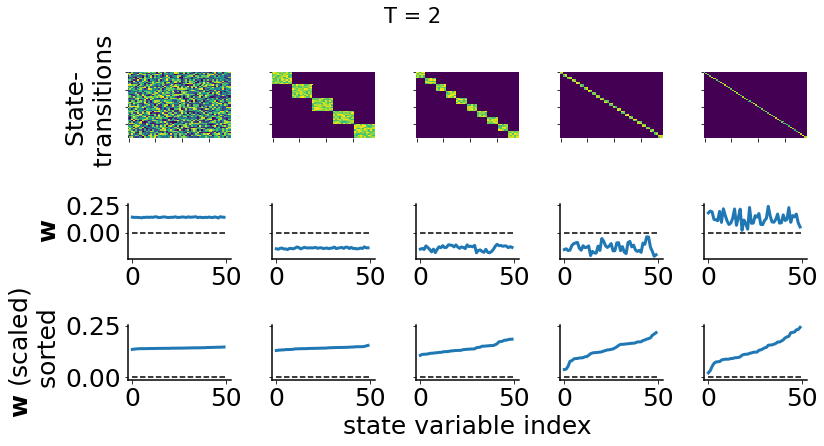

In [277]:
savefig = False

np.random.seed(40)

amin=1 # 0.001
amax=1.5 # 0.1
athresh=10
nics=10
x0mean=0.1
x0std=0.1
nblocks_list = [1,5,10,25,50]
nvarsblock_list = [50,10,5,2,1]
this_nT = 2

fig, ax = plt.subplots(3,5,figsize=(12,6.5),sharex='row',sharey='row',gridspec_kw={'height_ratios':[1.2,1,1]})
# plt.setp(ax,xticks=[0,50,100],xticklabels=[0,50,100])

for ii in range(len(nblocks_list)):
    nblocks = nblocks_list[ii]
    nvarsblock = nvarsblock_list[ii]
    Asim , x0sim = gen_block_lin_sys(N_blocks=nblocks,N_vars_per_block=nvarsblock,Ai_min=amin,Ai_max=amax,N_initial_conditions=nics,x0_mean=x0mean,x0_std=x0std)
    Gsim = gram_matrix(Asim,x0sim,nT=this_nT,reduced=False)
    Dsim, Vsim = sp.linalg.eig(Gsim,left=False,right=True)
    Wsim = Vsim[:,0:1].T[0]
#     Wsim = (Wsim - np.min(Wsim)) / (np.max(Wsim) - np.min(Wsim))
        
    sns.heatmap(Asim,ax=ax[0,ii],cbar=False,cmap='viridis')
    ax[0,ii].set_xticklabels(labels=[]); ax[0,ii].set_yticklabels(labels=[])
    ax[1,ii].plot(Wsim)
    ax[1,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)
    ax[2,ii].plot(np.sort(np.abs(Wsim)))
    ax[2,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)

ax[-1,2].set_xlabel('state variable index')    
ax[0,0].set_ylabel('State- \n transitions'); ax[1,0].set_ylabel(r'$\mathbf{w}$'); ax[2,0].set_ylabel(r'$\mathbf{w}$ (scaled)' + '\n sorted'); 
plt.suptitle(f'T = {this_nT}',fontsize=21)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/obs_max_expos_T2.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

unstable system of dim 50 generated
unstable system of dim 50 generated


/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated


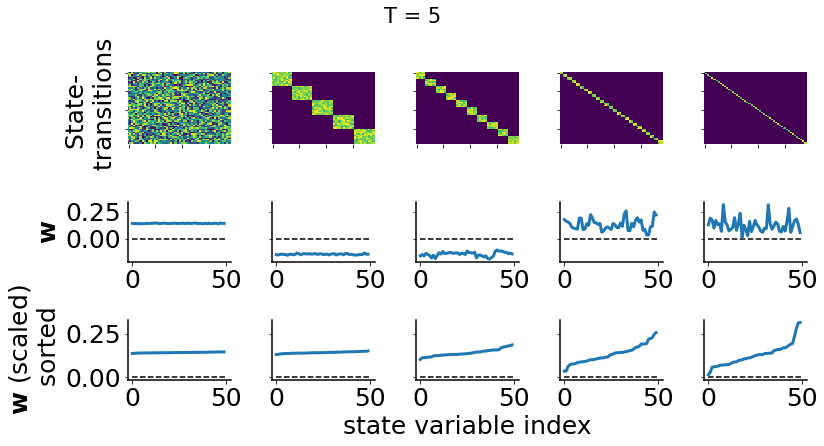

In [276]:
savefig = False

np.random.seed(40)

amin=1 # 0.001
amax=1.5 # 0.1
athresh=10
nics=10
x0mean=0.1
x0std=0.1
nblocks_list = [1,5,10,25,50]
nvarsblock_list = [50,10,5,2,1]
this_nT = 5

fig, ax = plt.subplots(3,5,figsize=(12,6.5),sharex='row',sharey='row',gridspec_kw={'height_ratios':[1.2,1,1]})
# plt.setp(ax,xticks=[0,50,100],xticklabels=[0,50,100])

for ii in range(len(nblocks_list)):
    nblocks = nblocks_list[ii]
    nvarsblock = nvarsblock_list[ii]
    Asim , x0sim = gen_block_lin_sys(N_blocks=nblocks,N_vars_per_block=nvarsblock,Ai_min=amin,Ai_max=amax,N_initial_conditions=nics,x0_mean=x0mean,x0_std=x0std)
    Gsim = gram_matrix(Asim,x0sim,nT=this_nT,reduced=False)
    Dsim, Vsim = sp.linalg.eig(Gsim,left=False,right=True)
    Wsim = Vsim[:,0:1].T[0]
#     Wsim = (Wsim - np.min(Wsim)) / (np.max(Wsim) - np.min(Wsim))
        
    sns.heatmap(Asim,ax=ax[0,ii],cbar=False,cmap='viridis')
    ax[0,ii].set_xticklabels(labels=[]); ax[0,ii].set_yticklabels(labels=[])
    ax[1,ii].plot(Wsim)
    ax[1,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)
    ax[2,ii].plot(np.sort(np.abs(Wsim)))
    ax[2,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)

ax[-1,2].set_xlabel('state variable index')    
ax[0,0].set_ylabel('State- \n transitions'); ax[1,0].set_ylabel(r'$\mathbf{w}$'); ax[2,0].set_ylabel(r'$\mathbf{w}$ (scaled)' + '\n sorted'); 
plt.suptitle(f'T = {this_nT}',fontsize=21)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/obs_max_expos_T5.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated


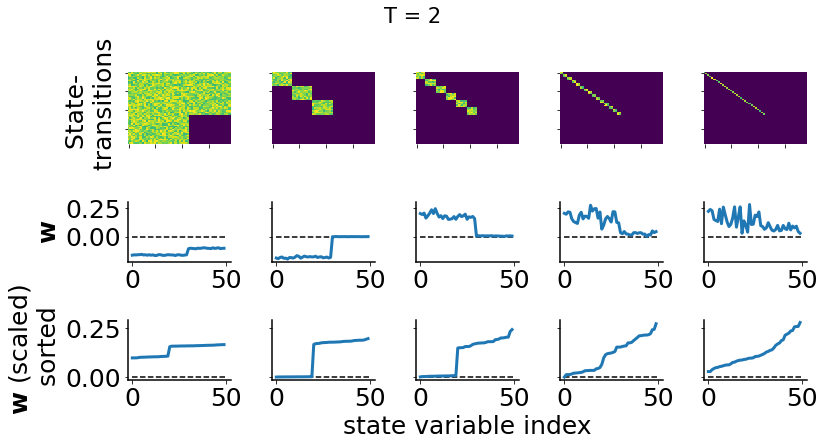

In [275]:
savfig = False

np.random.seed(40)

amin=1 # 0.001
amax=1.5 # 0.1
athresh=10
nics=10
x0mean=0.1
x0std=0.1
nblocks_list = [1,5,10,25,50]
nvarsblock_list = [50,10,5,2,1]
this_nT = 2

fig, ax = plt.subplots(3,5,figsize=(12,6.5),sharex='row',sharey='row',gridspec_kw={'height_ratios':[1.2,1,1]})
# plt.setp(ax,xticks=[0,50,100],xticklabels=[0,50,100])

for ii in range(len(nblocks_list)):
    nblocks = nblocks_list[ii]
    nvarsblock = nvarsblock_list[ii]
    Asim , x0sim = gen_block_lin_sys(N_blocks=nblocks,N_vars_per_block=nvarsblock,Ai_min=amin,Ai_max=amax,N_initial_conditions=nics,x0_mean=x0mean,x0_std=x0std)
    Asim[-20:,-20:] = 0.0
    Gsim = gram_matrix(Asim,x0sim,nT=this_nT,reduced=False)
    Dsim, Vsim = sp.linalg.eig(Gsim,left=False,right=True)
    Wsim = Vsim[:,0:1].T[0]
#     Wsim = (Wsim - np.min(Wsim)) / (np.max(Wsim) - np.min(Wsim))
        
    sns.heatmap(Asim,ax=ax[0,ii],cbar=False,cmap='viridis')
    ax[0,ii].set_xticklabels(labels=[]); ax[0,ii].set_yticklabels(labels=[])
    ax[1,ii].plot(Wsim)
    ax[1,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)
    ax[2,ii].plot(np.sort(np.abs(Wsim)))
    ax[2,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)

ax[-1,2].set_xlabel('state variable index')    
ax[0,0].set_ylabel('State- \n transitions'); ax[1,0].set_ylabel(r'$\mathbf{w}$'); ax[2,0].set_ylabel(r'$\mathbf{w}$ (scaled)' + '\n sorted'); 
plt.suptitle(f'T = {this_nT}',fontsize=21)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/obs_max_expos_T2_zeros.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

unstable system of dim 50 generated
unstable system of dim 50 generated


/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


unstable system of dim 50 generated
unstable system of dim 50 generated
unstable system of dim 50 generated


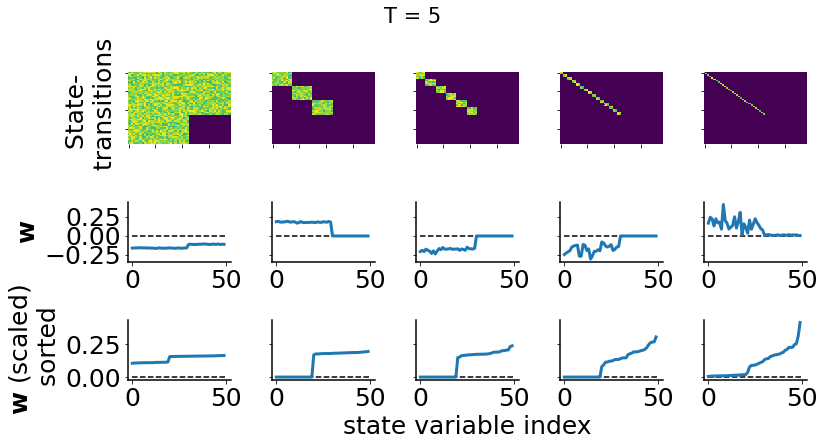

In [274]:
savefig = False

np.random.seed(40)

amin=1 # 0.001
amax=1.5 # 0.1
athresh=10
nics=10
x0mean=0.1
x0std=0.1
nblocks_list = [1,5,10,25,50]
nvarsblock_list = [50,10,5,2,1]
this_nT = 5

fig, ax = plt.subplots(3,5,figsize=(12,6.5),sharex='row',sharey='row',gridspec_kw={'height_ratios':[1.2,1,1]})
# plt.setp(ax,xticks=[0,50,100],xticklabels=[0,50,100])

for ii in range(len(nblocks_list)):
    nblocks = nblocks_list[ii]
    nvarsblock = nvarsblock_list[ii]
    Asim , x0sim = gen_block_lin_sys(N_blocks=nblocks,N_vars_per_block=nvarsblock,Ai_min=amin,Ai_max=amax,N_initial_conditions=nics,x0_mean=x0mean,x0_std=x0std)
    Asim[-20:,-20:] = 0.0
    Gsim = gram_matrix(Asim,x0sim,nT=this_nT,reduced=False)
    Dsim, Vsim = sp.linalg.eig(Gsim,left=False,right=True)
    Wsim = Vsim[:,0:1].T[0]
#     Wsim = (Wsim - np.min(Wsim)) / (np.max(Wsim) - np.min(Wsim))
        
    sns.heatmap(Asim,ax=ax[0,ii],cbar=False,cmap='viridis')
    ax[0,ii].set_xticklabels(labels=[]); ax[0,ii].set_yticklabels(labels=[])
    ax[1,ii].plot(Wsim)
    ax[1,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)
    ax[2,ii].plot(np.sort(np.abs(Wsim)))
    ax[2,ii].plot([0,50],[0,0],'--k',lw=1.5,zorder=0)


ax[-1,2].set_xlabel('state variable index')
ax[0,0].set_ylabel('State- \n transitions'); ax[1,0].set_ylabel(r'$\mathbf{w}$'); ax[2,0].set_ylabel(r'$\mathbf{w}$ (scaled)' + '\n sorted'); 
plt.suptitle(f'T = {this_nT}',fontsize=21)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/obs_max_expos_T5_zeros.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

What pathways are the top 20 genes involved in?

In [271]:
# protein name, molecular function, biological process

pd.DataFrame({'locus_tag': [locus_tags_keep[x] for x in sorted_inds_n[::-1][:20]],
 'gene': [genes_keep[x] for x in sorted_inds_n[::-1][:20]],
 'protein_name':['50S ribosomal protein L34',
                'Putative outer membrane protein',
                'ATP-dependent Clp protease proteolytic subunit',
                'Translational regulator CsrA',
                'ATP synthase subunit a',
                '30S ribosomal protein S11',
                '50S ribosomal protein L6',
                '50S ribosomal protein L10',
                'ATP synthase subunit b',
                'Coenzyme PQQ synthesis protein A',
                'Ribose-phosphate pyrophosphokinase',
                'Probable Fe(2+)-trafficking protein',
                '30S ribosomal protein S7',
                'Arginine deiminase',
                '50S ribosomal protein L16',
                '30S ribosomal protein S13',
                'Phenylalanine--tRNA ligase alpha subunit',
                '30S ribosomal protein S2',
                '50S ribosomal protein L3',
                'DUF1161 domain-containing protein'],
'molecular function':['structural constituent of ribosome',
                      'N/A',
                      'ATP-dependent peptidase activity; serine-type endopeptidase activity',
                      "mRNA 5'-UTR binding","proton-transporting ATP synthase activity, rotational mechanism",
                      'structural constituent of ribosome',
                      'structural constituent of ribosome',
                      'structural constituent of ribosome',
                      'hydrolase activity; proton-transporting ATP synthase activity, rotational mechanism',
                      'N/A',
                      'ATP binding; kinase activity; magnesium ion binding; ribose phosphate diphosphokinase activiity',
                      'N/A',
                      'rRNA binding; structural constituent of ribosome; tRNA binding',
                      'arginine deiminase activity',
                      'rRNA binding; structural constituent of ribosome; tRNA binding',
                      'rRNA binding; structural constituent of ribosome; tRNA binding',
                      'ATP binding; magnesium ion binding; phenylalanine-tRNA ligase activity; tRNA binding',
                      'structural constituent of ribosome',
                      'rRNA binding; structural constituent of ribosome',
                      'N/A'],
'biological process':['translation',
                     'N/A',
                     'proteolysis',
                     'regulation of translational initation and carbohydrate metabolic process',
                     'N/A',
                     'translation',
                     'translation',
                     'translation',
                     'N/A',
                     'pyrroloquinoline quinone biosynthetic process',
                     '5-phosphoribose 1-diphosphate biosynthetic process; nucleotide biosynthetic process; phosphorylation; ribonucleoside monophosphate biosynthetic process',
                     'N/A',
                     'translation',
                     'arginine catabolic process to  ornithine',
                     'translation',
                     'translation',
                     'phenylalanyl-tRNA aminoacylation',
                     'translation',
                     'translation',
                     'N/A'] })

,locus_tag,gene,protein_name,molecular function,biological process
0,PFLU_6136,rpmH,50S ribosomal protein L34,structural constituent of ribosome,translation
1,PFLU_5860,N/A,Putative outer membrane protein,N/A,N/A
2,PFLU_3929,N/A,ATP-dependent Clp protease proteolytic subunit,ATP-dependent peptidase activity; serine-type ...,proteolysis
3,PFLU_4746,N/A,Translational regulator CsrA,mRNA 5'-UTR binding,regulation of translational initation and carb...
4,PFLU_6124,atpB,ATP synthase subunit a,"proton-transporting ATP synthase activity, rot...",N/A
5,PFLU_5504,rpsK,30S ribosomal protein S11,structural constituent of ribosome,translation
6,PFLU_5512,rplF,50S ribosomal protein L6,structural constituent of ribosome,translation
7,PFLU_5536,rplJ,50S ribosomal protein L10,structural constituent of ribosome,translation
8,PFLU_6122,atpF,ATP synthase subunit b,hydrolase activity; proton-transporting ATP sy...,N/A
9,PFLU_5598,pqqA,Coenzyme PQQ synthesis protein A,N/A,pyrroloquinoline quinone biosynthetic process
